In [31]:
import numpy as np
import pandas as pd

import backtesting as bt
import yfinance as yf
import talib as ta

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 300

In [32]:
class SMAcrossover(bt.Strategy):
    '''Estratégia de cruzamento de médias móveis.'''

    n_slow = 20
    n_fast = 8

    def init(self):
        self.sma_slow = self.I(ta.SMA, self.data['Close'], timeperiod=self.n_slow, plot=True, overlay=True)
        self.sma_fast = self.I(ta.SMA, self.data['Close'], timeperiod=self.n_fast, plot=True, overlay=True)

    def next(self):
    
        if bt.lib.crossover(self.sma_fast, self.sma_slow):
            if self.position.is_short:
                self.position.close()
                self.buy()
            
            if not self.position:
                self.buy(size=1)

        if bt.lib.crossover(self.sma_slow, self.sma_fast):
            if self.position.is_long:
                self.position.close()
                self.sell()
            
            if not self.position:
                self.sell()
        
        positions[self.dict_name[0]][self.dict_name[1]].append([self.data.index[-1], self.position.size])


class CloseCrossover(bt.Strategy):
    '''Estratégia de cruzamento de fechamento.'''

    n_SMA = 20

    def init(self):
        self.SMA = self.I(ta.SMA, self.data['Close'], timeperiod=self.n_SMA, plot=True, overlay=True)

    def next(self):
    
        if bt.lib.crossover(self.data['Close'], self.SMA):
            if self.position.is_short:
                self.position.close()
                self.buy()
            
            if not self.position:
                self.buy(size=1)

        if bt.lib.crossover(self.SMA, self.data['Close']):
            if self.position.is_long:
                self.position.close()
                self.sell()
            
            if not self.position:
                self.sell(size=1)

In [33]:
ibov = yf.download('^BVSP', start='2005-01-01', end='2022-08-10')

[*********************100%***********************]  1 of 1 completed


In [34]:
positions = {}
positions['SMAcrossover_curto'] = {}
# SMAcrossover curto

for n_slow in tqdm(range(5, 51, 5)):
    for n_fast in range(3, 48, 3):
        if n_fast > n_slow:
            continue

        positions['SMAcrossover_curto'][f'SMAcrossover_({n_slow}, {n_fast})'] = []

        SMAcrossover.n_slow = n_slow
        SMAcrossover.n_fast = n_fast
        SMAcrossover.dict_name = ['SMAcrossover_curto', f'SMAcrossover_({n_slow}, {n_fast})']

        bck = bt.Backtest(ibov.loc['2005':], SMAcrossover, cash=1_000_000, trade_on_close=True)
        stats = bck.run()

100%|██████████| 10/10 [00:33<00:00,  3.32s/it]


In [35]:
# SMAcrossover longo
positions['SMAcrossover_longo'] = {}

for n_slow in tqdm(range(20, 300, 20)):
    for n_fast in range(10, 200, 10):
        if n_fast > n_slow:
            continue

        positions['SMAcrossover_longo'][f'SMAcrossover_({n_slow}, {n_fast})'] = []

        SMAcrossover.n_slow = n_slow
        SMAcrossover.n_fast = n_fast
        SMAcrossover.dict_name = ['SMAcrossover_longo', f'SMAcrossover_({n_slow}, {n_fast})']

        bck = bt.Backtest(ibov.loc['2005':], SMAcrossover, cash=1_000_000, trade_on_close=True)
        stats = bck.run()

100%|██████████| 14/14 [00:58<00:00,  4.21s/it]


In [36]:
for p in positions['SMAcrossover_curto']:
    positions['SMAcrossover_curto'][p] = pd.DataFrame(positions['SMAcrossover_curto'][p], columns=['Date', p])

SMAcrossover_curto = pd.concat([positions['SMAcrossover_curto'][p].set_index('Date') for p in positions['SMAcrossover_curto']], axis=1)

In [37]:
alta_curto = (abs(SMAcrossover_curto[SMAcrossover_curto > 0]).fillna(0).sum(1) / abs(SMAcrossover_curto).fillna(0).sum(1))
baixa_curto = (abs(SMAcrossover_curto[SMAcrossover_curto < 0]).fillna(0).sum(1) / abs(SMAcrossover_curto).fillna(0).sum(1))

<AxesSubplot:>

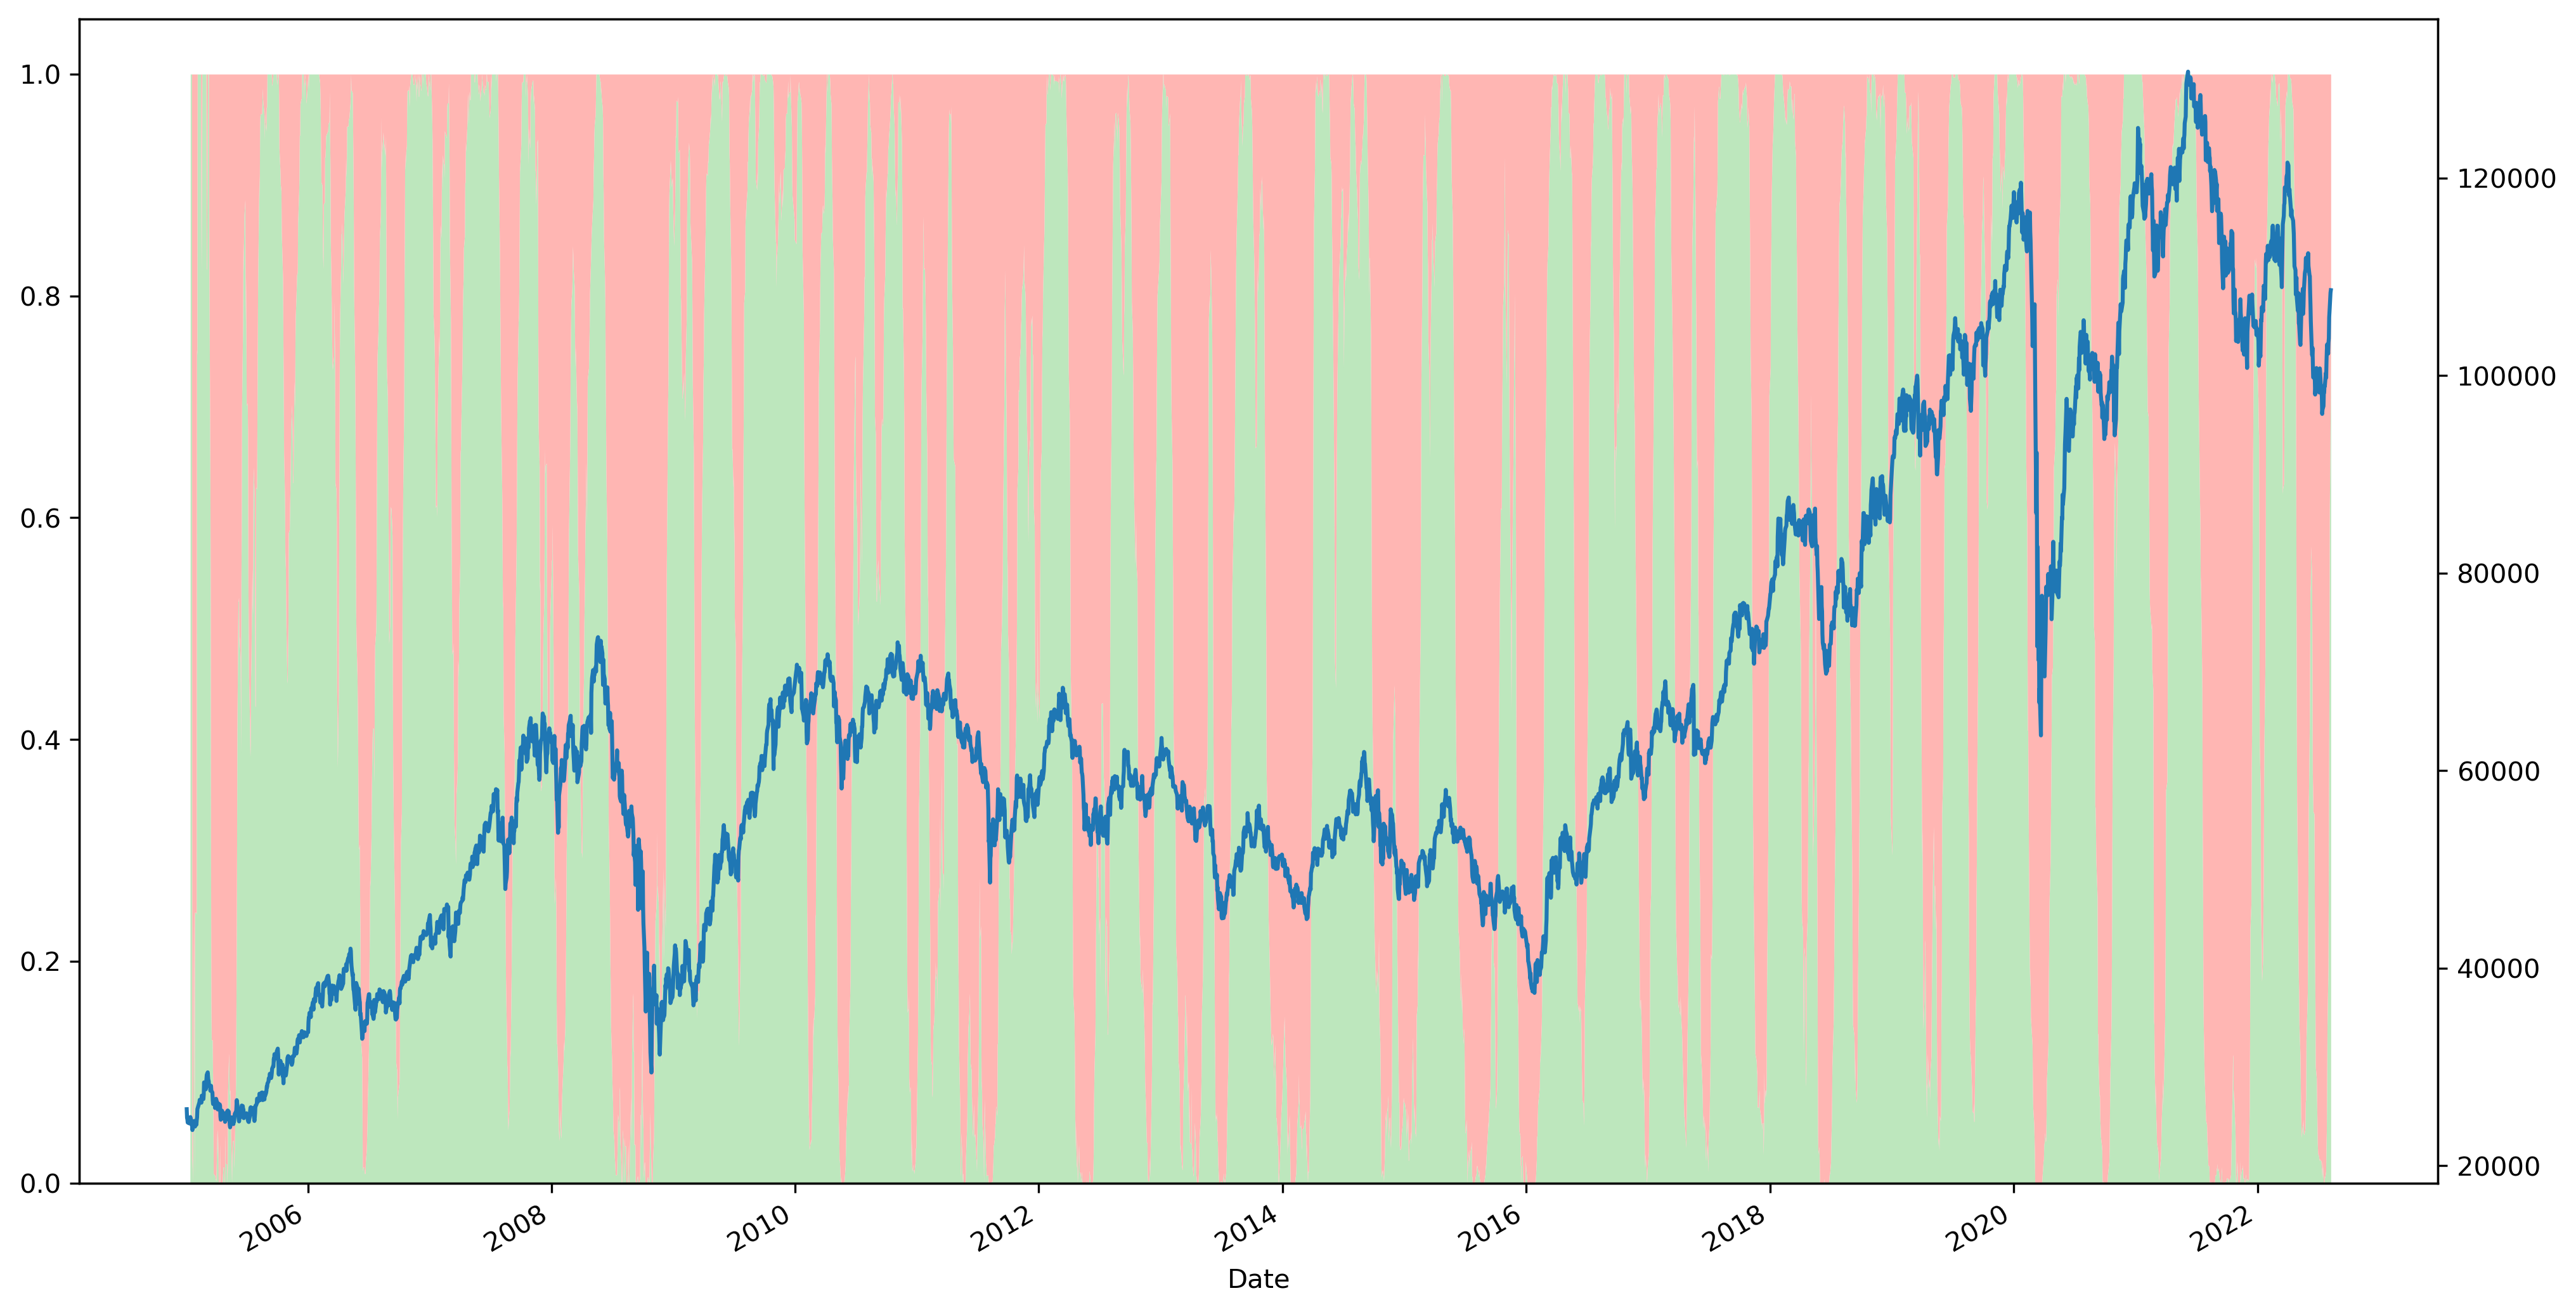

In [38]:
pd.concat([alta_curto, baixa_curto], axis=1).plot(kind='area', color=['#BDE7BD', '#FFB6B3'], linewidth=0, legend=False)
ibov['Close'].plot(secondary_y=True)

<AxesSubplot:>

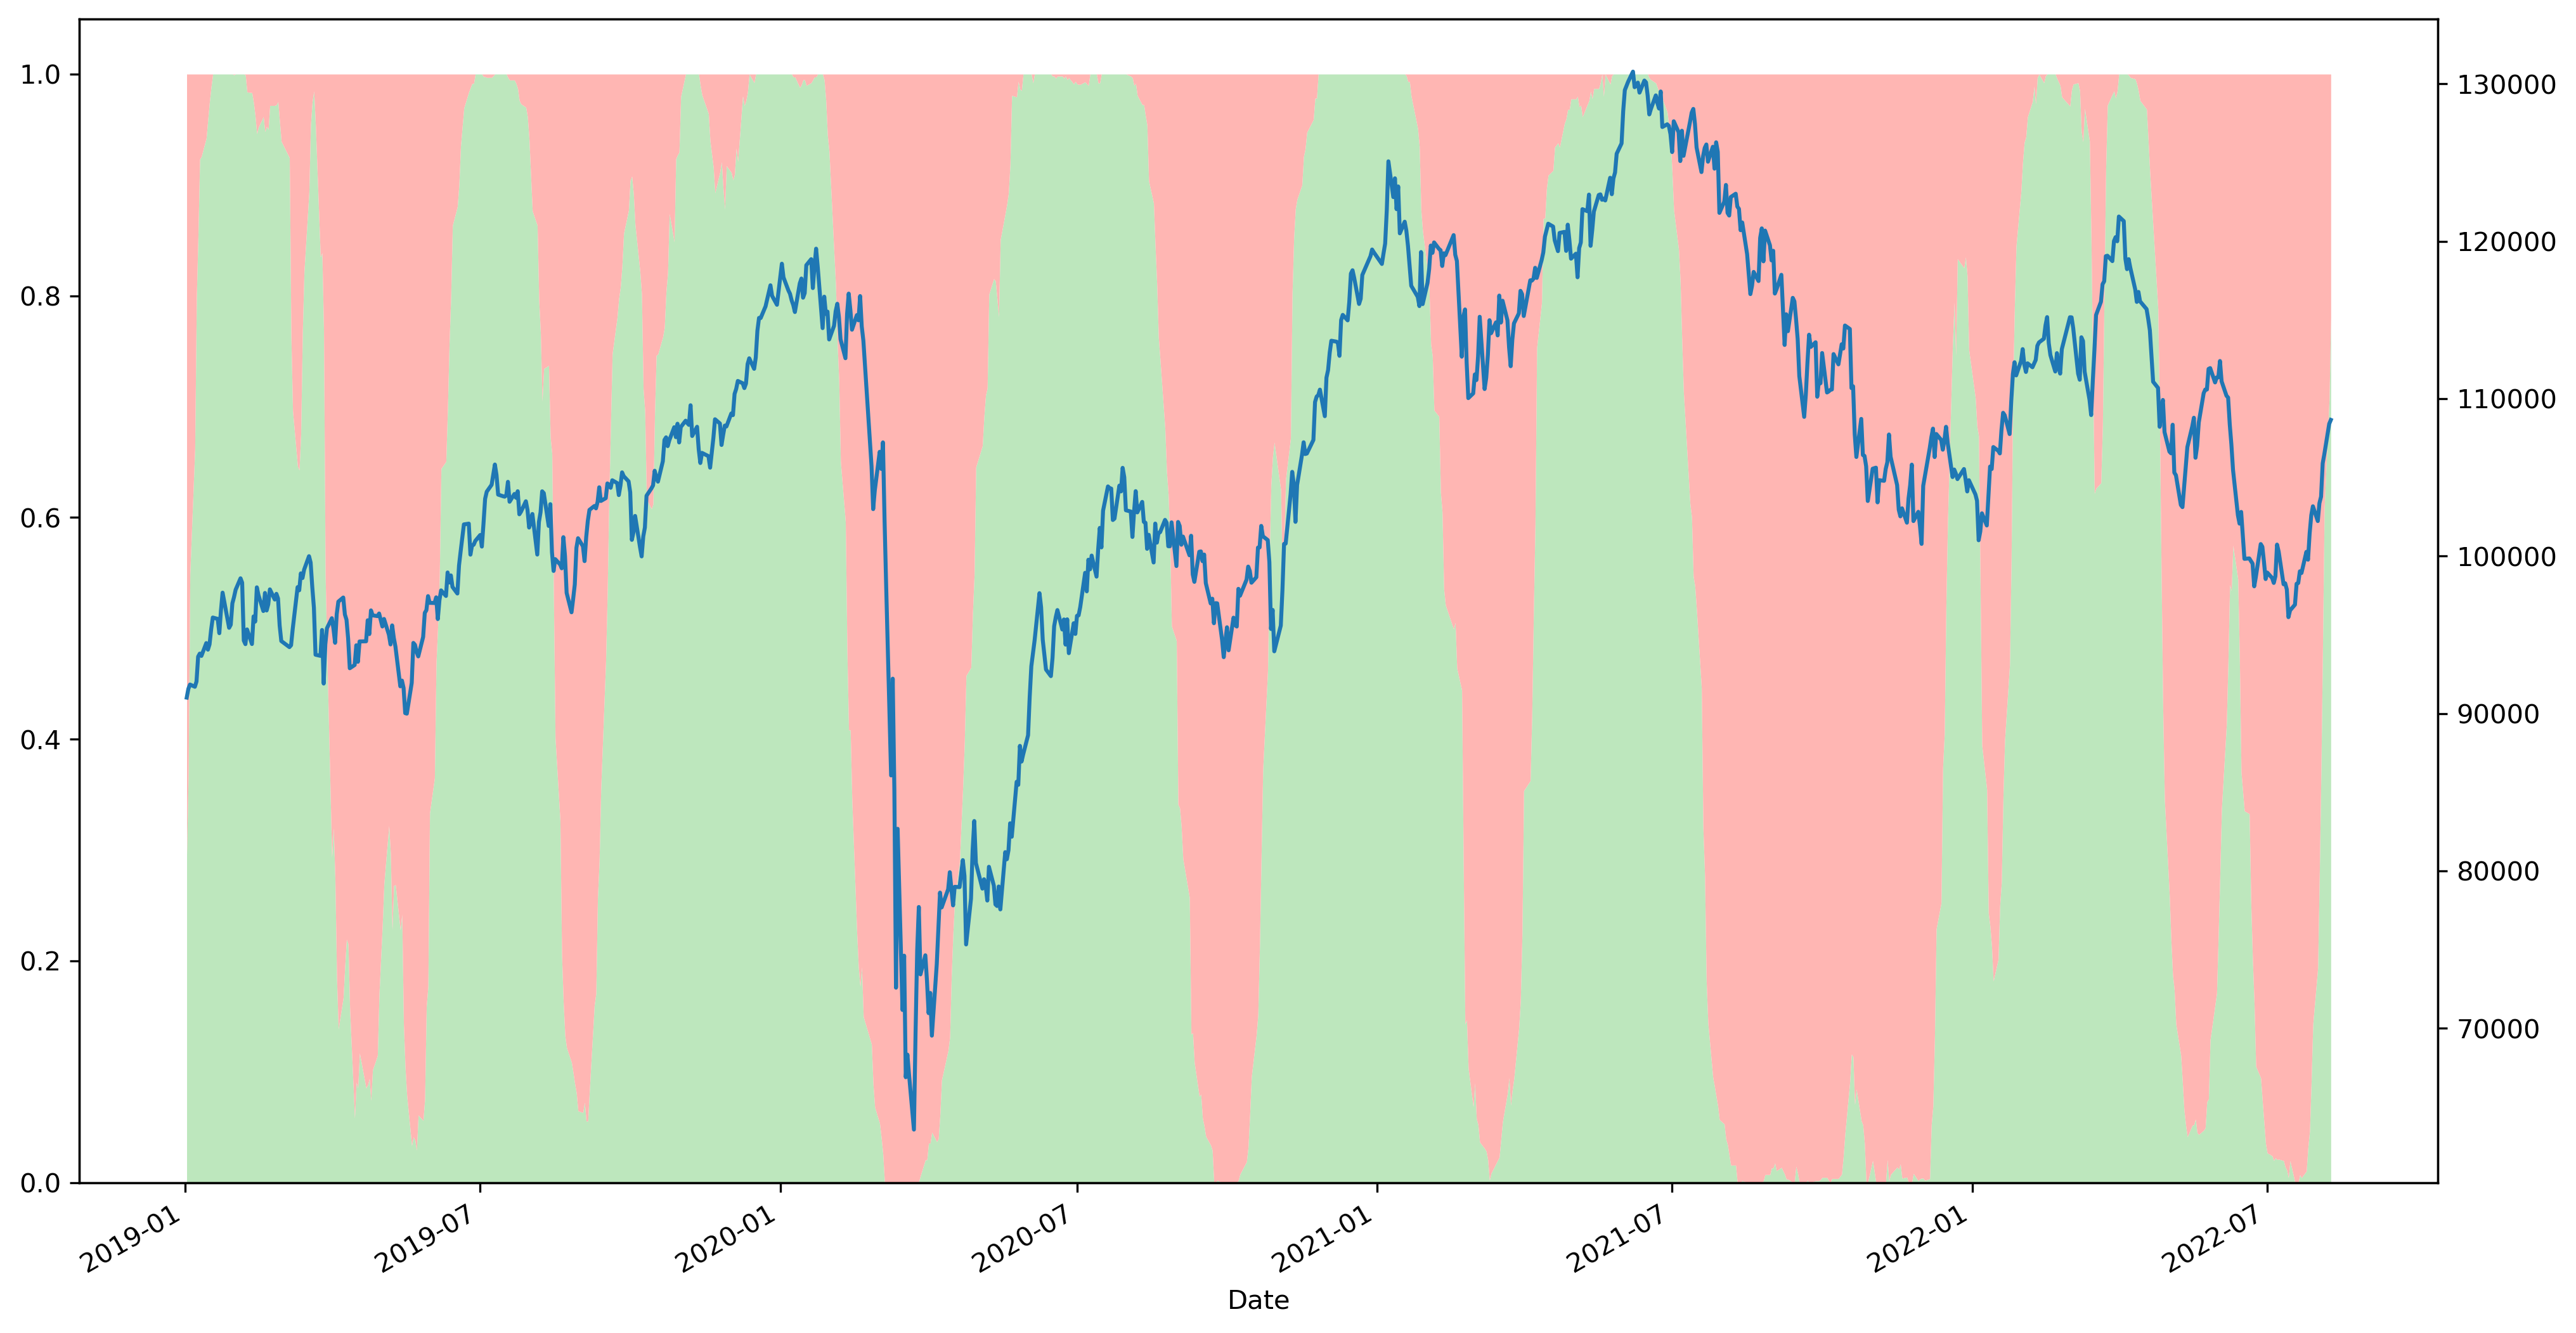

In [39]:
pd.concat([alta_curto.loc['2019':], baixa_curto.loc['2019':]], axis=1).plot(kind='area', color=['#BDE7BD', '#FFB6B3'], linewidth=0, legend=False)
ibov['Close'].loc['2019':].plot(secondary_y=True)

In [40]:
for p in positions['SMAcrossover_longo']:
    positions['SMAcrossover_longo'][p] = pd.DataFrame(positions['SMAcrossover_longo'][p], columns=['Date', p])

SMAcrossover_longo = pd.concat([positions['SMAcrossover_longo'][p].set_index('Date') for p in positions['SMAcrossover_longo']], axis=1)

In [41]:
alta_longo = (abs(SMAcrossover_longo[SMAcrossover_longo > 0]).fillna(0).sum(1) / abs(SMAcrossover_longo).fillna(0).sum(1))
baixa_longo = (abs(SMAcrossover_longo[SMAcrossover_longo < 0]).fillna(0).sum(1) / abs(SMAcrossover_longo).fillna(0).sum(1))

<AxesSubplot:>

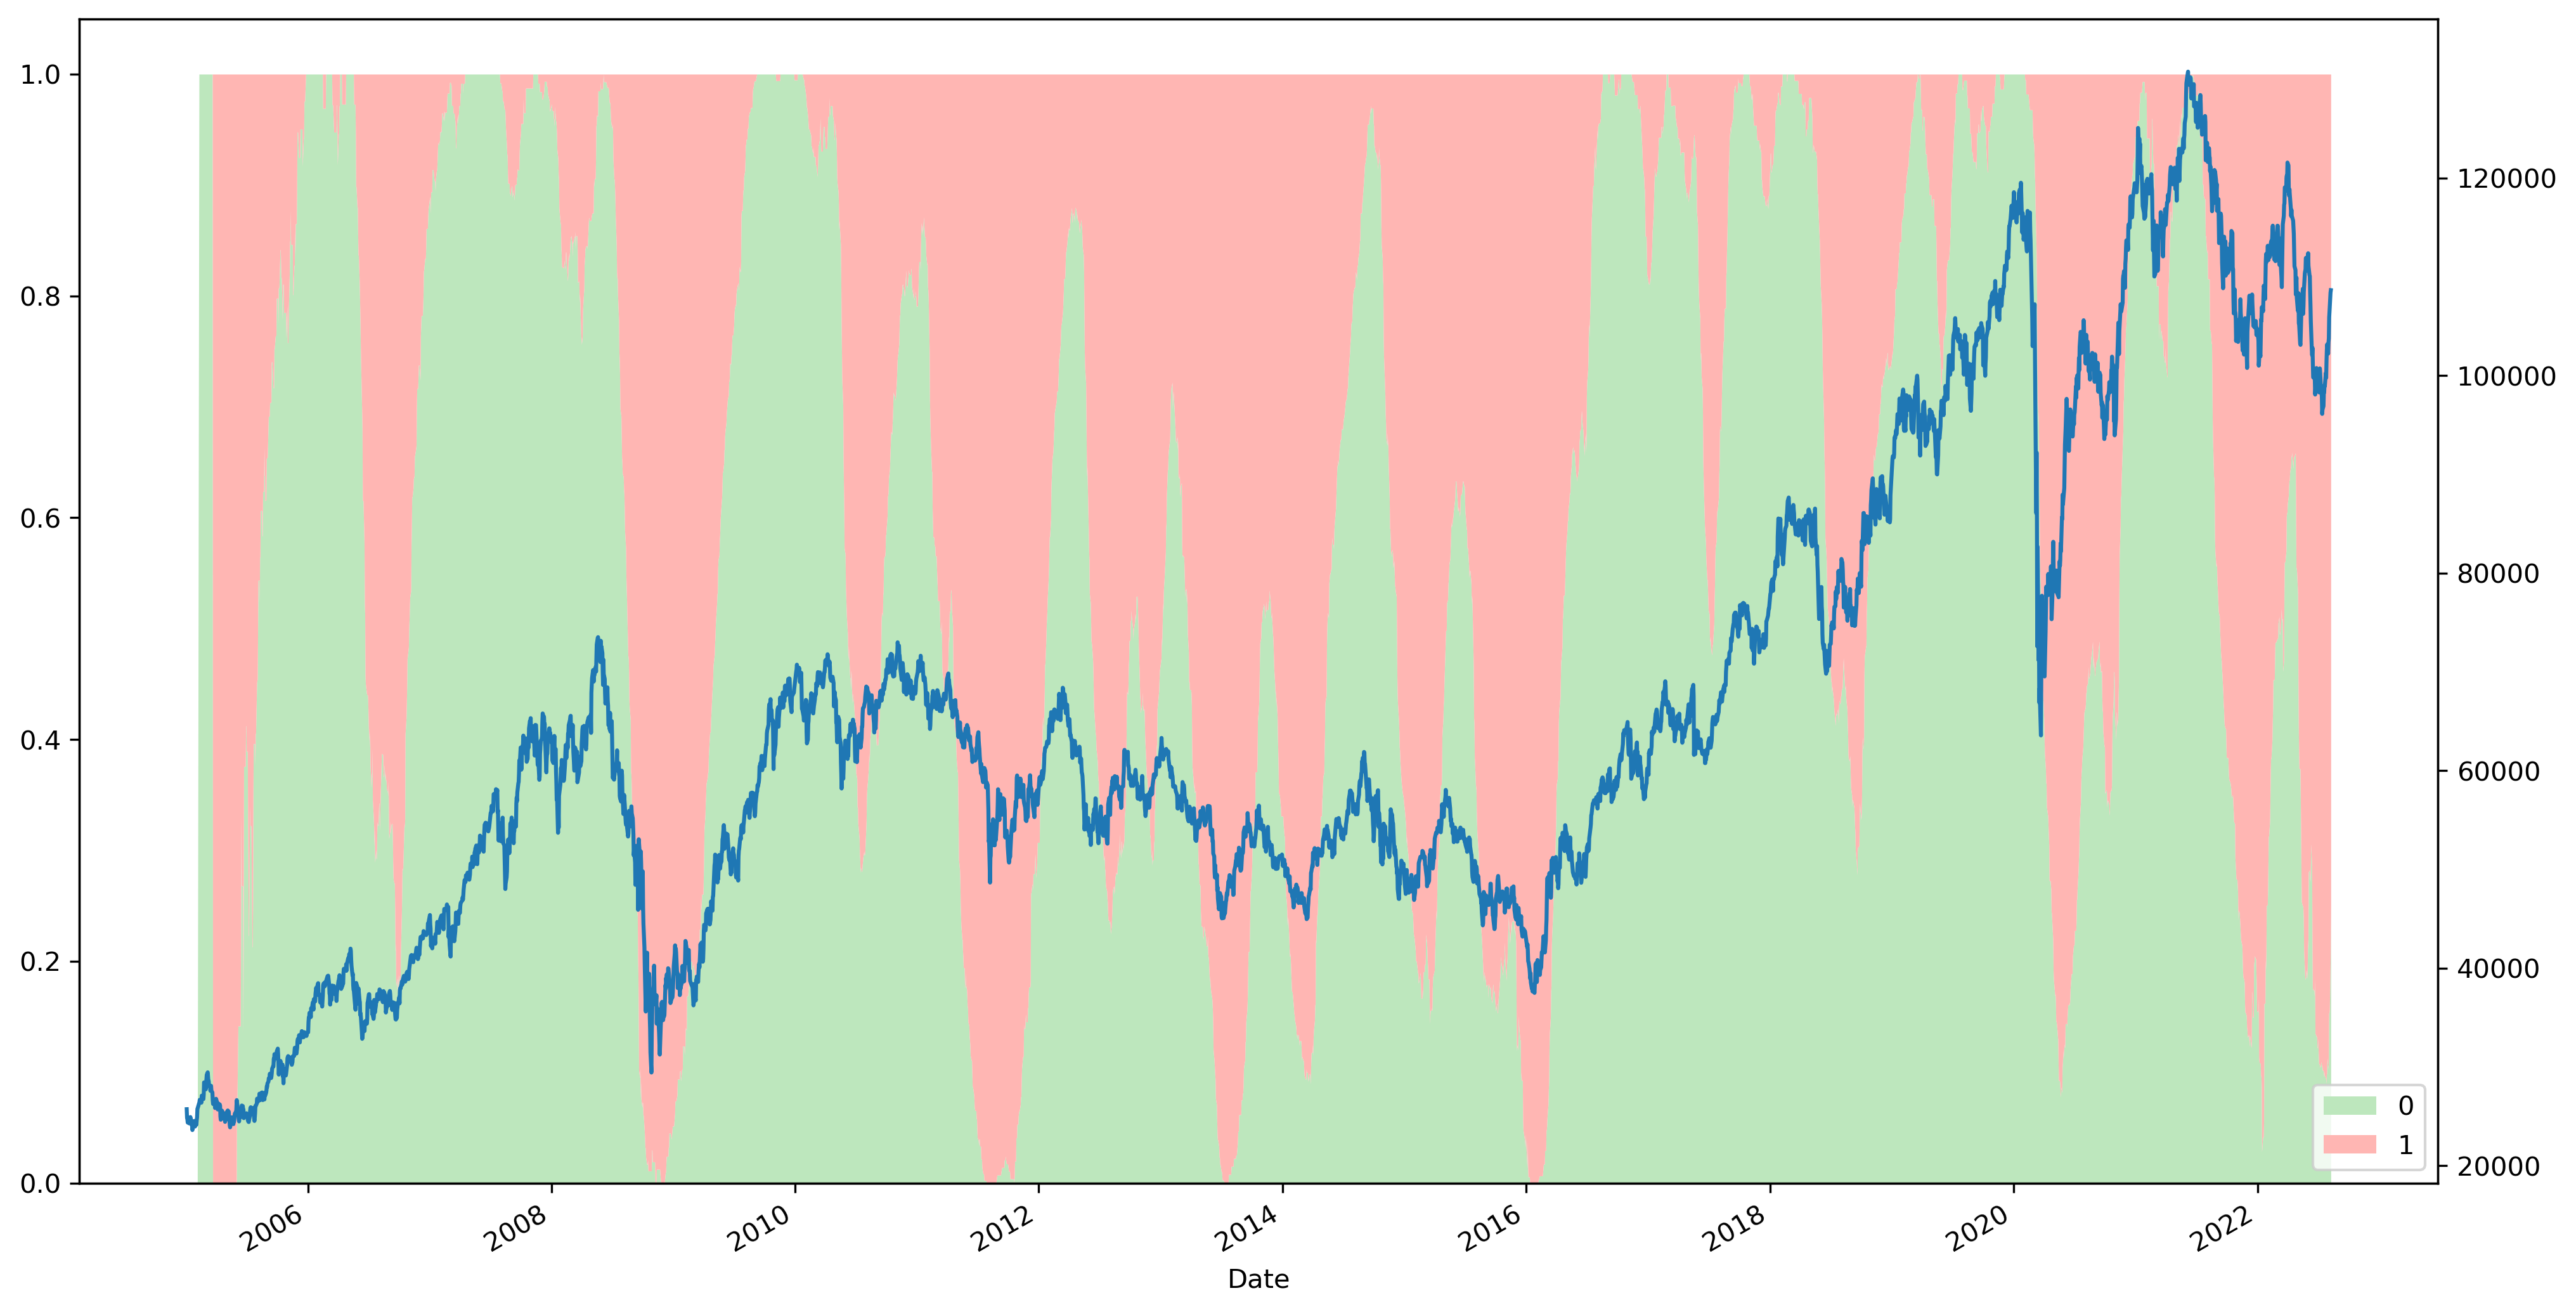

In [42]:
pd.concat([alta_longo, baixa_longo], axis=1).plot(kind='area', color=['#BDE7BD', '#FFB6B3'], linewidth=0)
ibov['Close'].plot(secondary_y=True)

<AxesSubplot:>

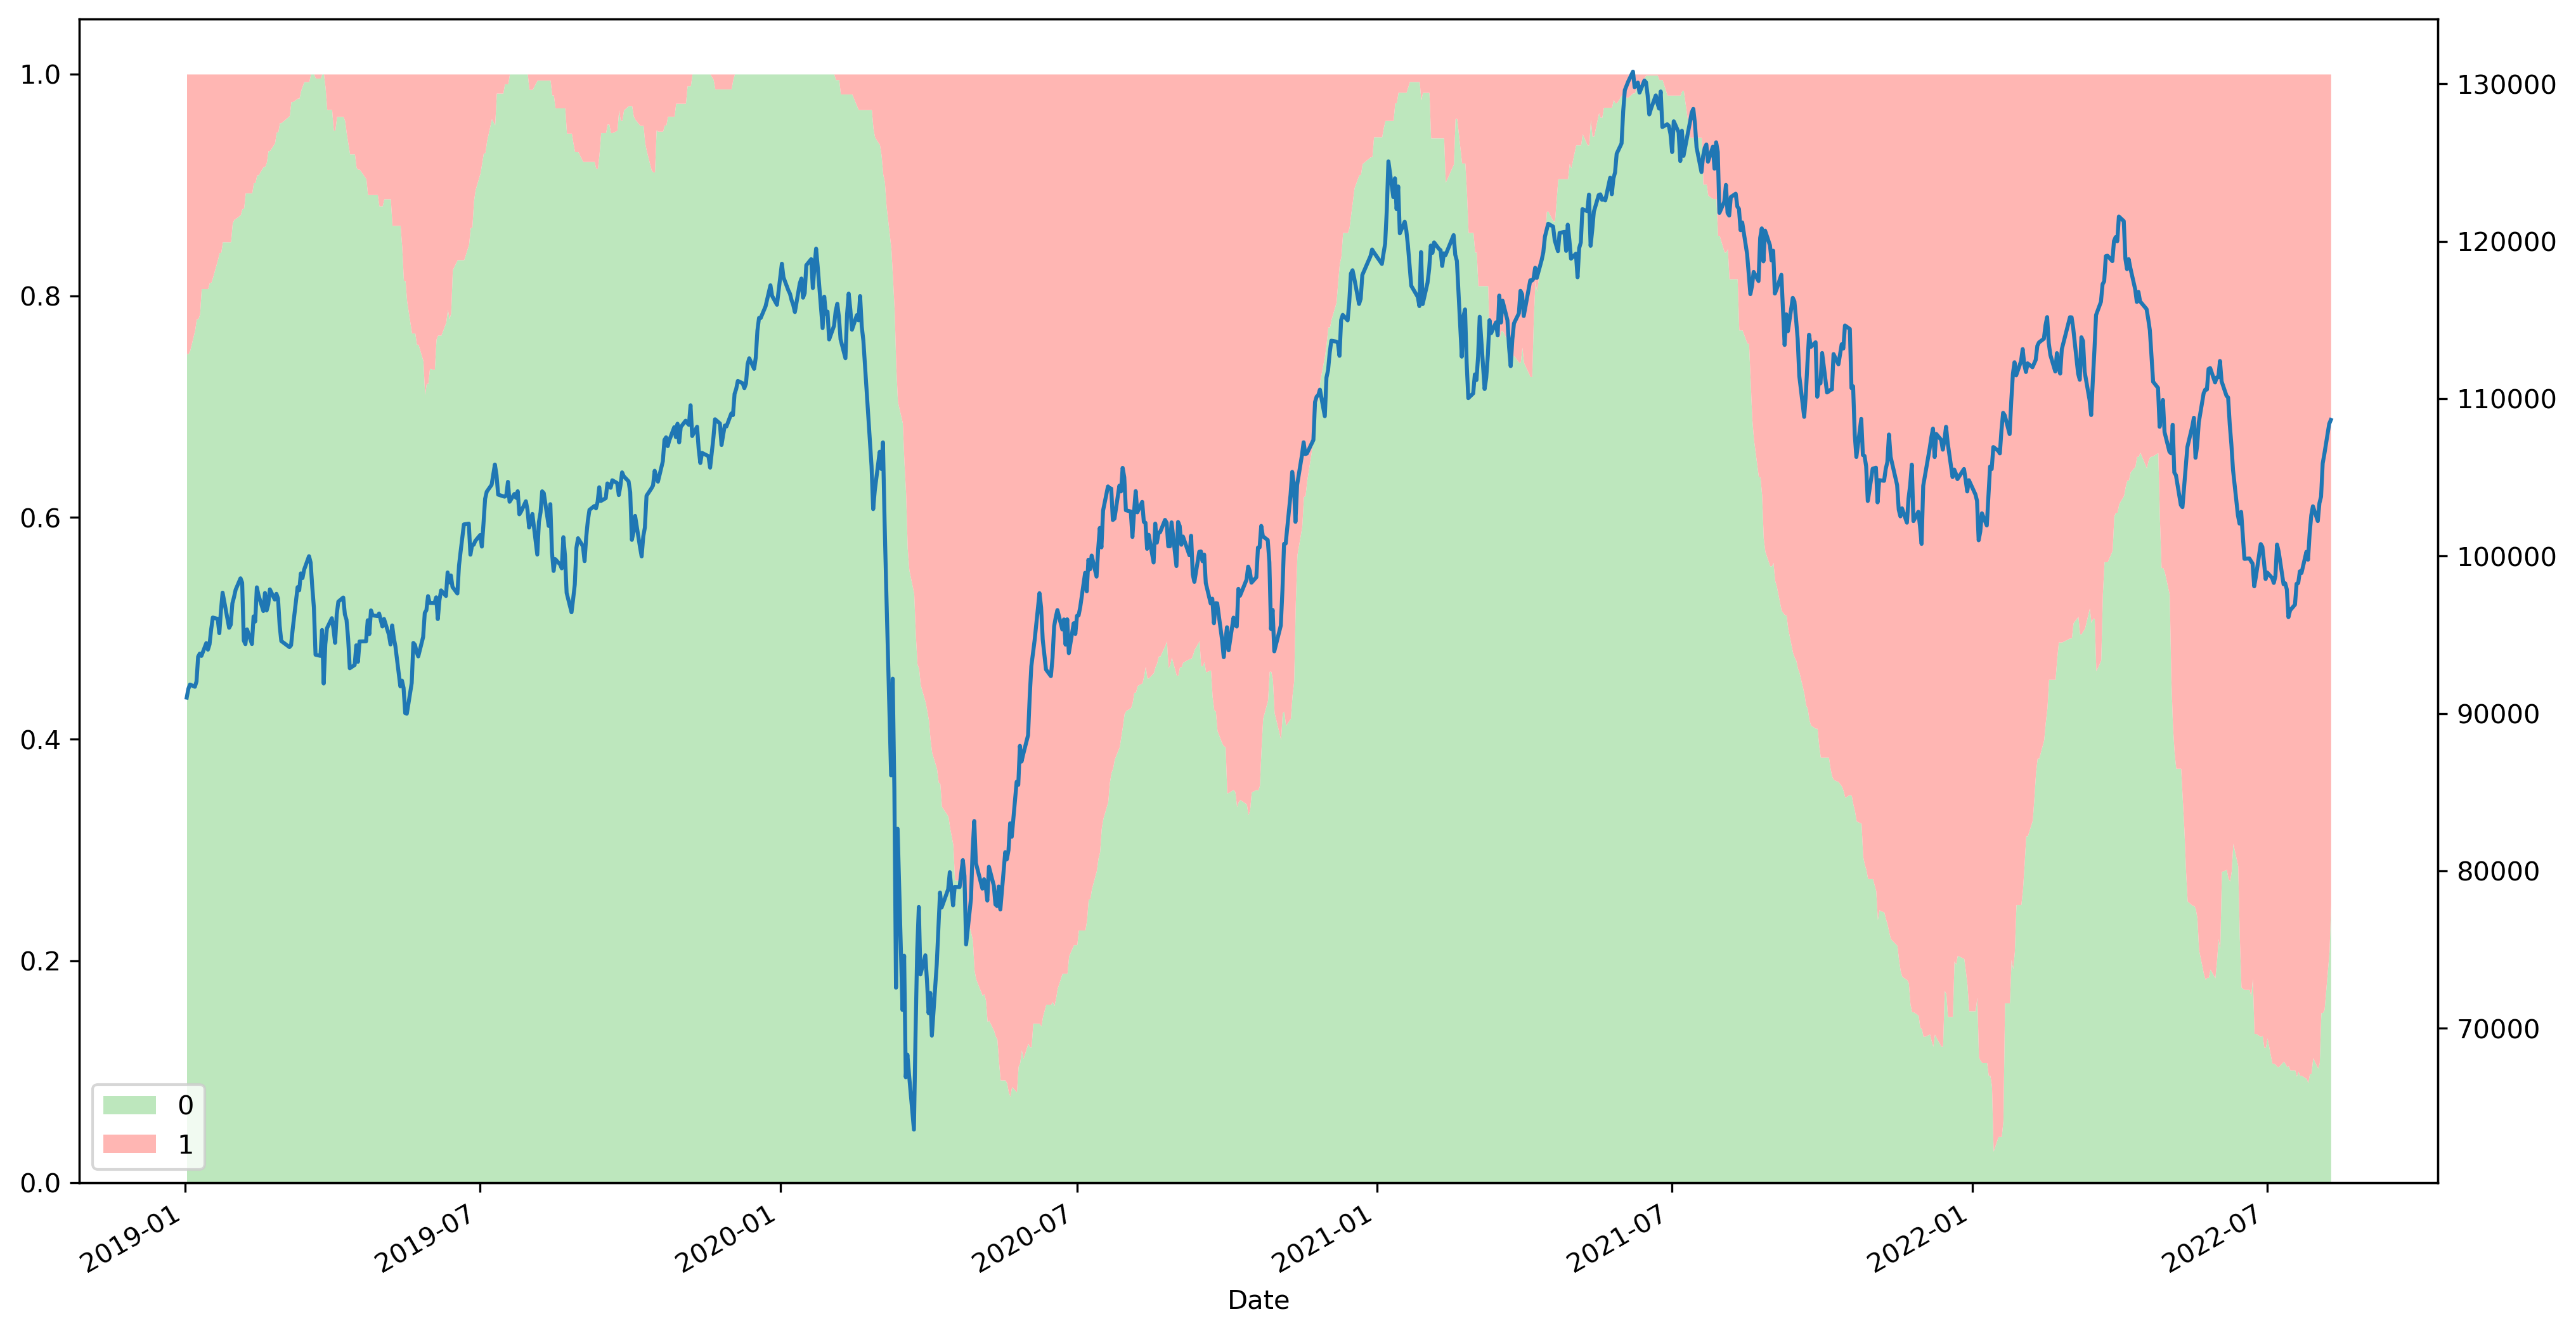

In [43]:
pd.concat([alta_longo.loc['2019':], baixa_longo.loc['2019':]], axis=1).plot(kind='area', color=['#BDE7BD', '#FFB6B3'], linewidth=0)
ibov['Close'].loc['2019':].plot(secondary_y=True)

In [44]:
ibov['mm200d'] = ibov['Close'].rolling(window=200).mean()
ibov['mm100d'] = ibov['Close'].rolling(window=100).mean()
ibov['mm50d'] = ibov['Close'].rolling(window=50).mean()

ibov['ratio200d'] = ibov['Close'] / ibov['mm200d']
ibov['ratio100d'] = ibov['Close'] / ibov['mm100d']
ibov['ratio50d'] = ibov['Close'] / ibov['mm50d']

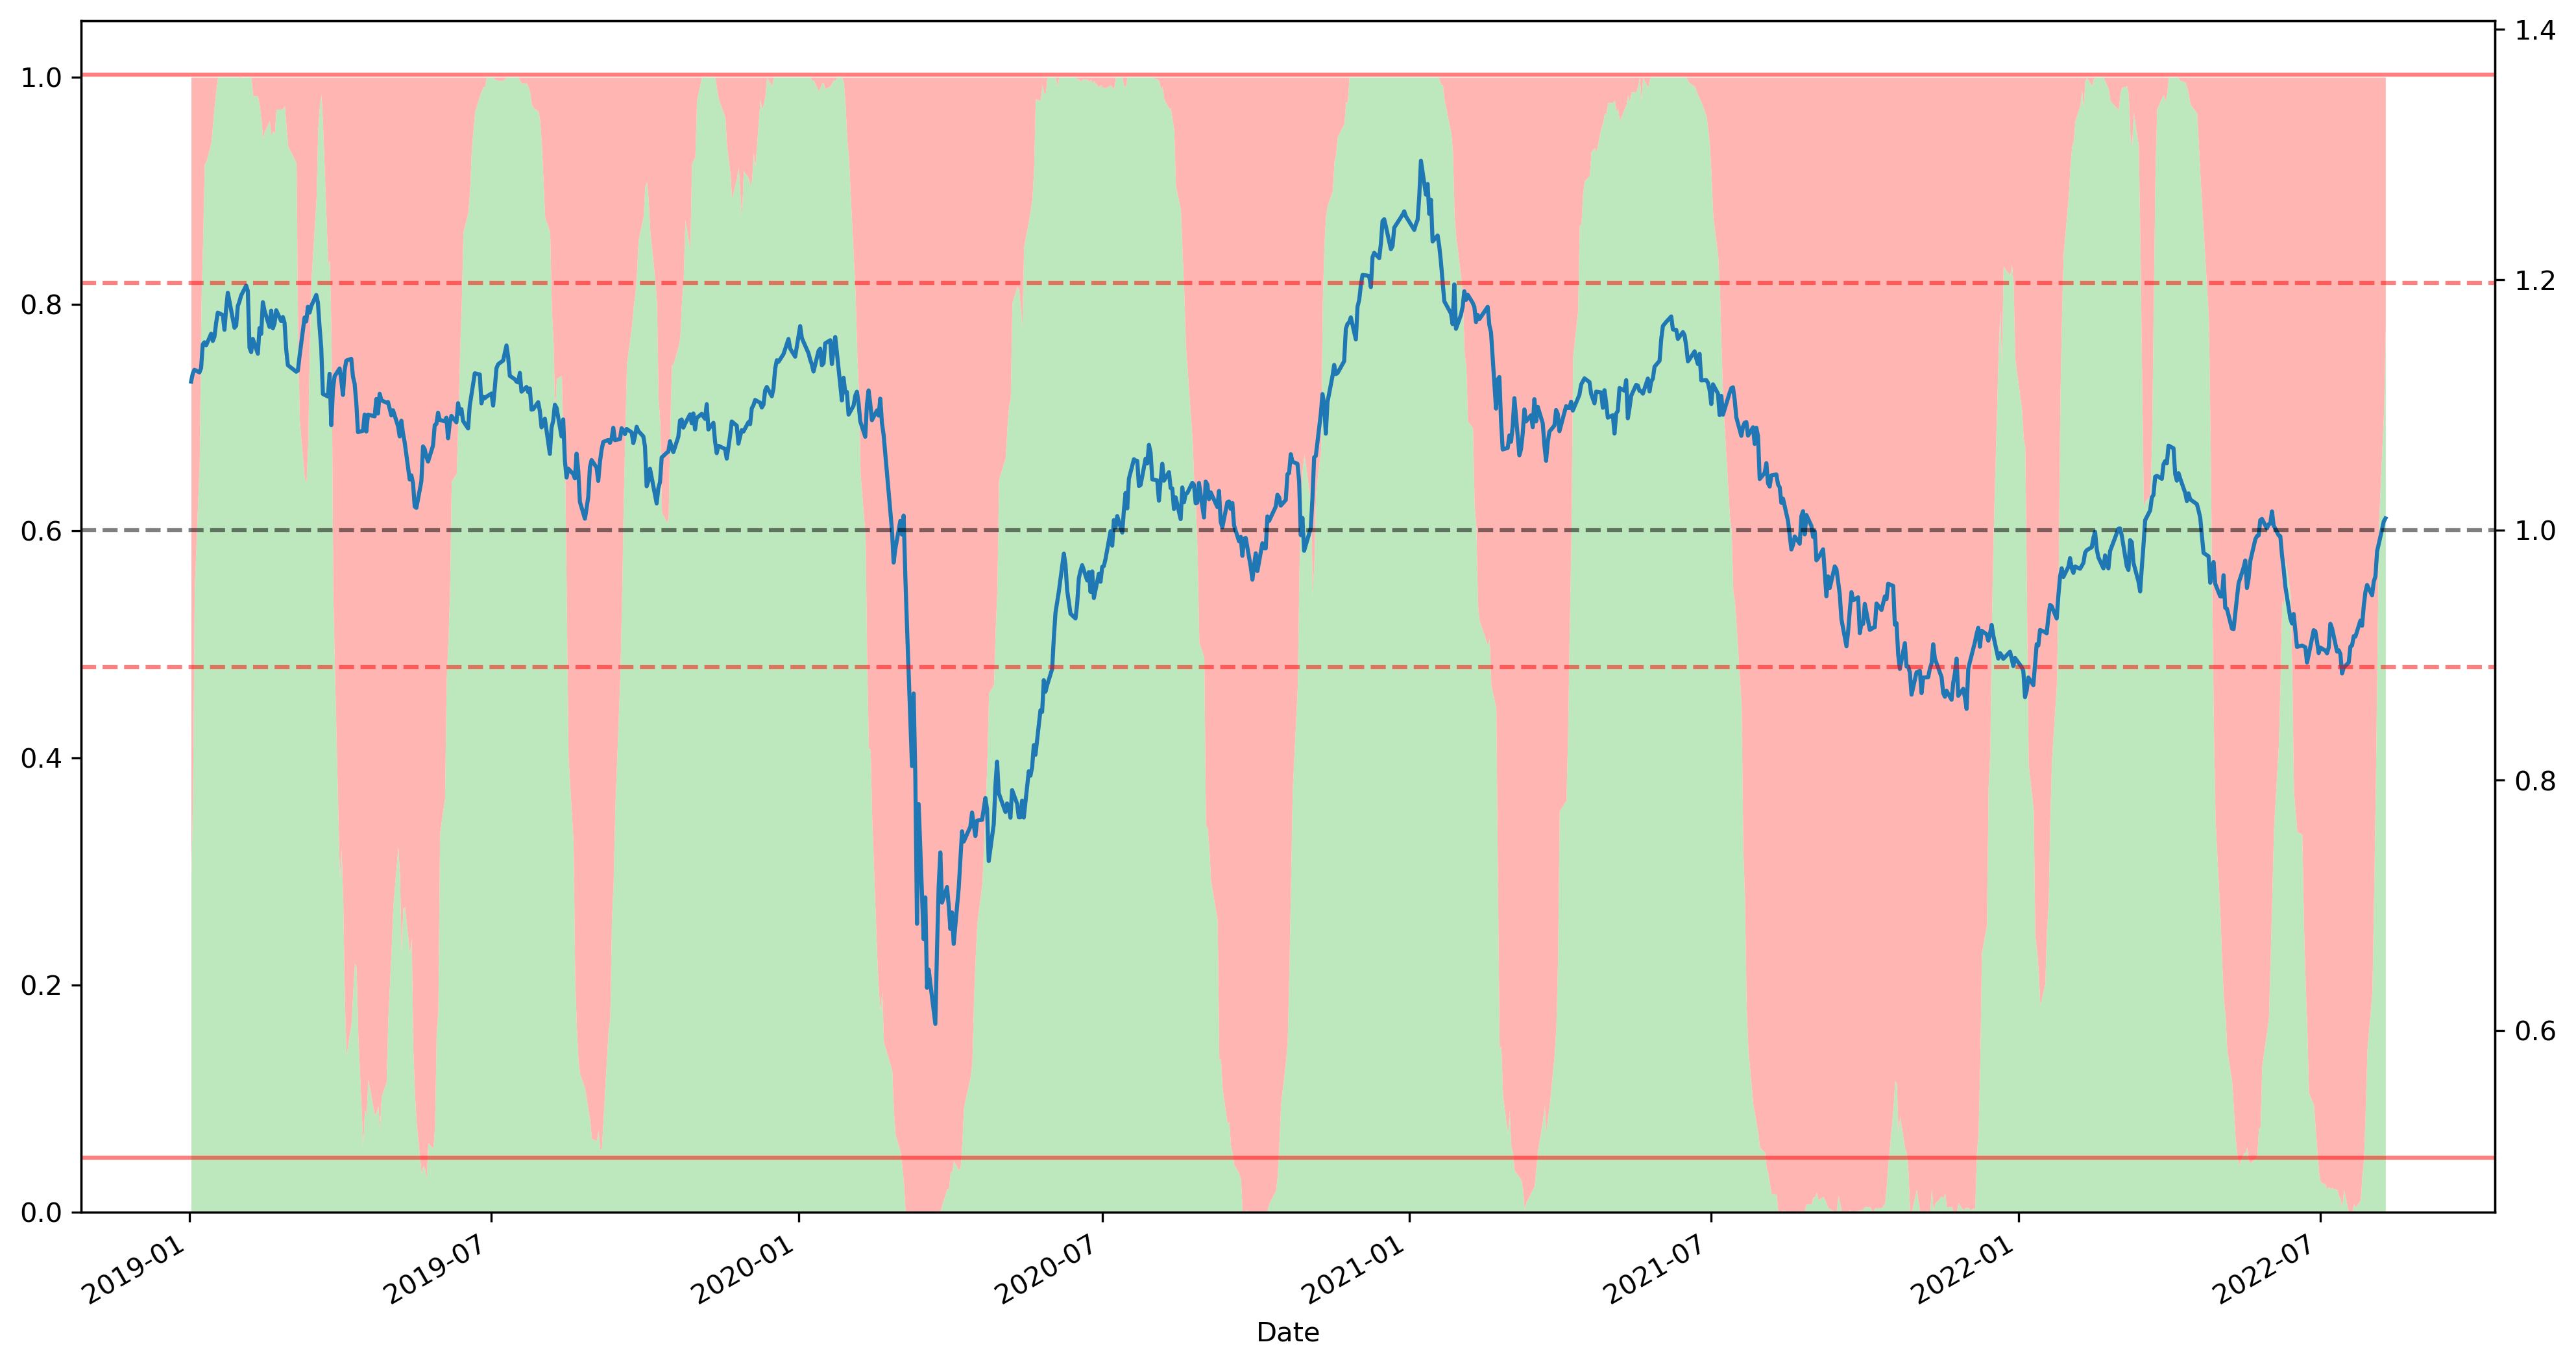

In [45]:
pd.concat([alta_curto.loc['2019':], baixa_curto.loc['2019':]], axis=1).plot(kind='area', color=['#BDE7BD', '#FFB6B3'], linewidth=0, legend=False)

ibov['ratio200d'].loc['2019':].plot(secondary_y=True)
plt.axhline(1, linestyle='--', color='black', alpha=0.5)
plt.axhline(ibov['ratio200d'].min(), linestyle='-', color='red', alpha=0.5)
plt.axhline(ibov['ratio200d'].max(), linestyle='-', color='red', alpha=0.5)
plt.axhline(ibov['ratio200d'].quantile(0.9), linestyle='--', color='red', alpha=0.5)
plt.axhline(ibov['ratio200d'].quantile(0.1), linestyle='--', color='red', alpha=0.5)

In [46]:
pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]

In [47]:
ibov['perc'] = np.nan

for i in range(201, ibov.shape[0]):
    ibov.iloc[i, -1] = pctrank(ibov['ratio200d'].iloc[:i])

<AxesSubplot:>

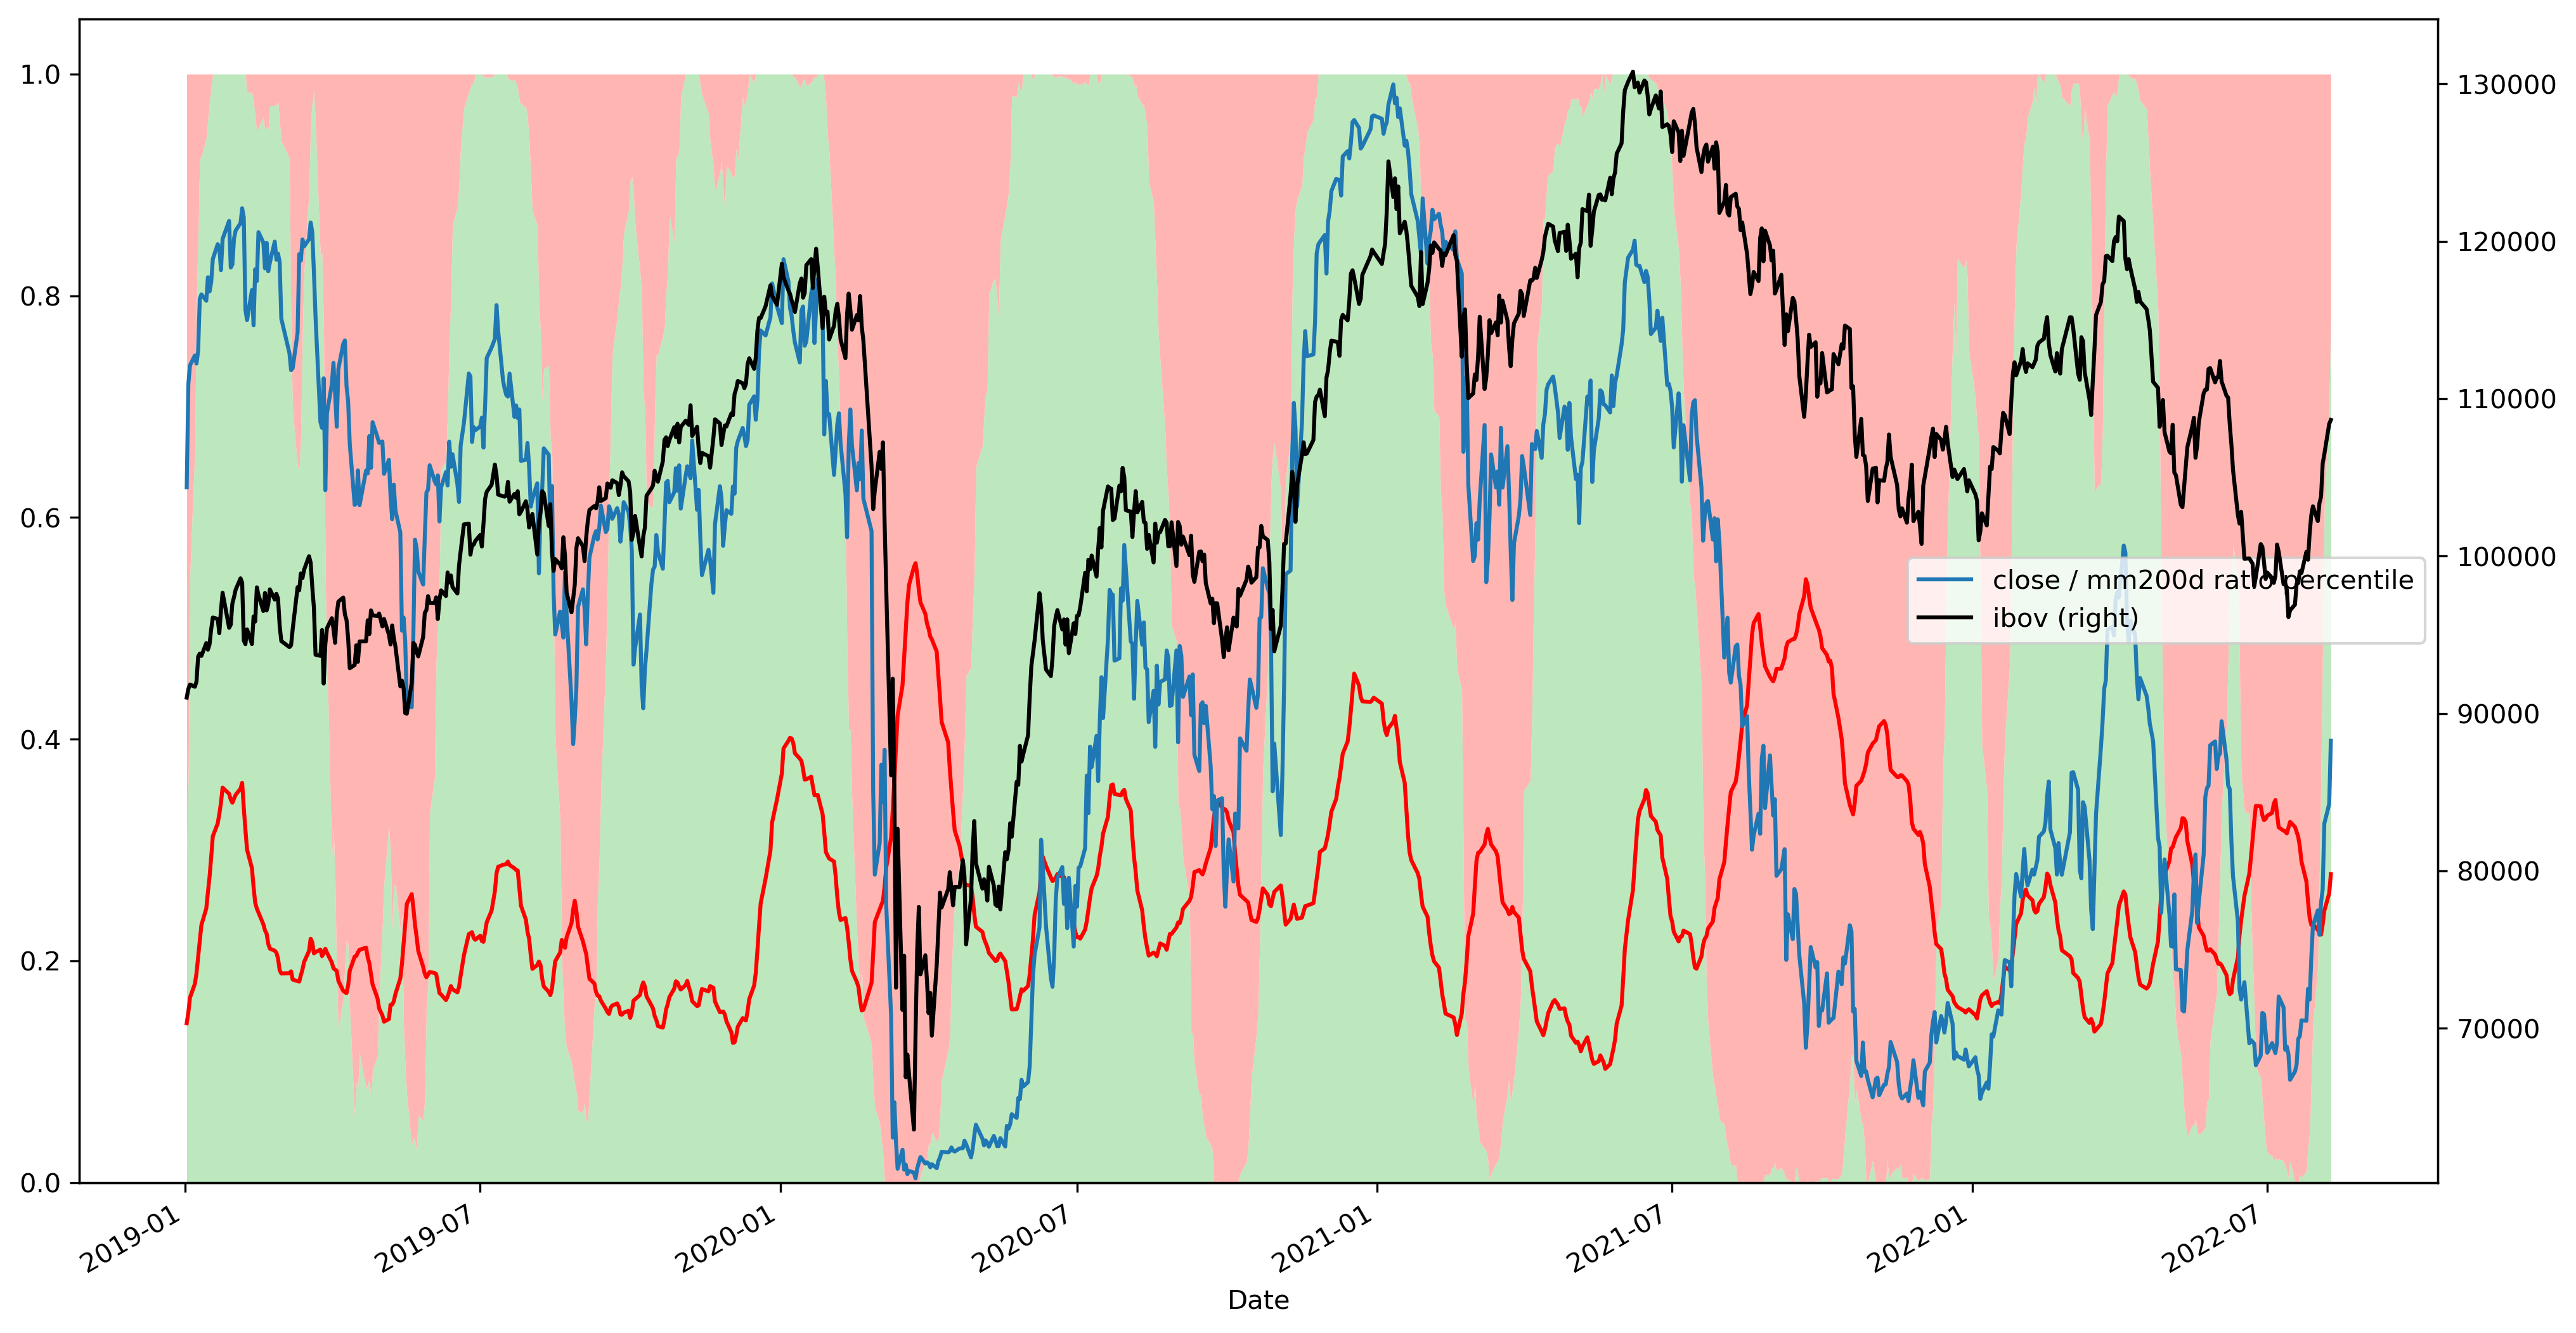

In [48]:
pd.concat([alta_curto, baixa_curto], axis=1).loc['2019':].plot(kind='area', color=['#BDE7BD', '#FFB6B3'], linewidth=0, legend=False)

(ta.ADX(ibov['High'], ibov['Low'], ibov['Close'], timeperiod=14)/100).loc['2019':].plot(color='red')
plt.grid(True, alpha=0.3)

ibov.loc['2019':]['perc'].plot(label='close / mm200d ratio percentile', legend=True)

ibov.loc['2019':]['Close'].plot(secondary_y=True, color='black', label='ibov', legend=True)

<AxesSubplot:>

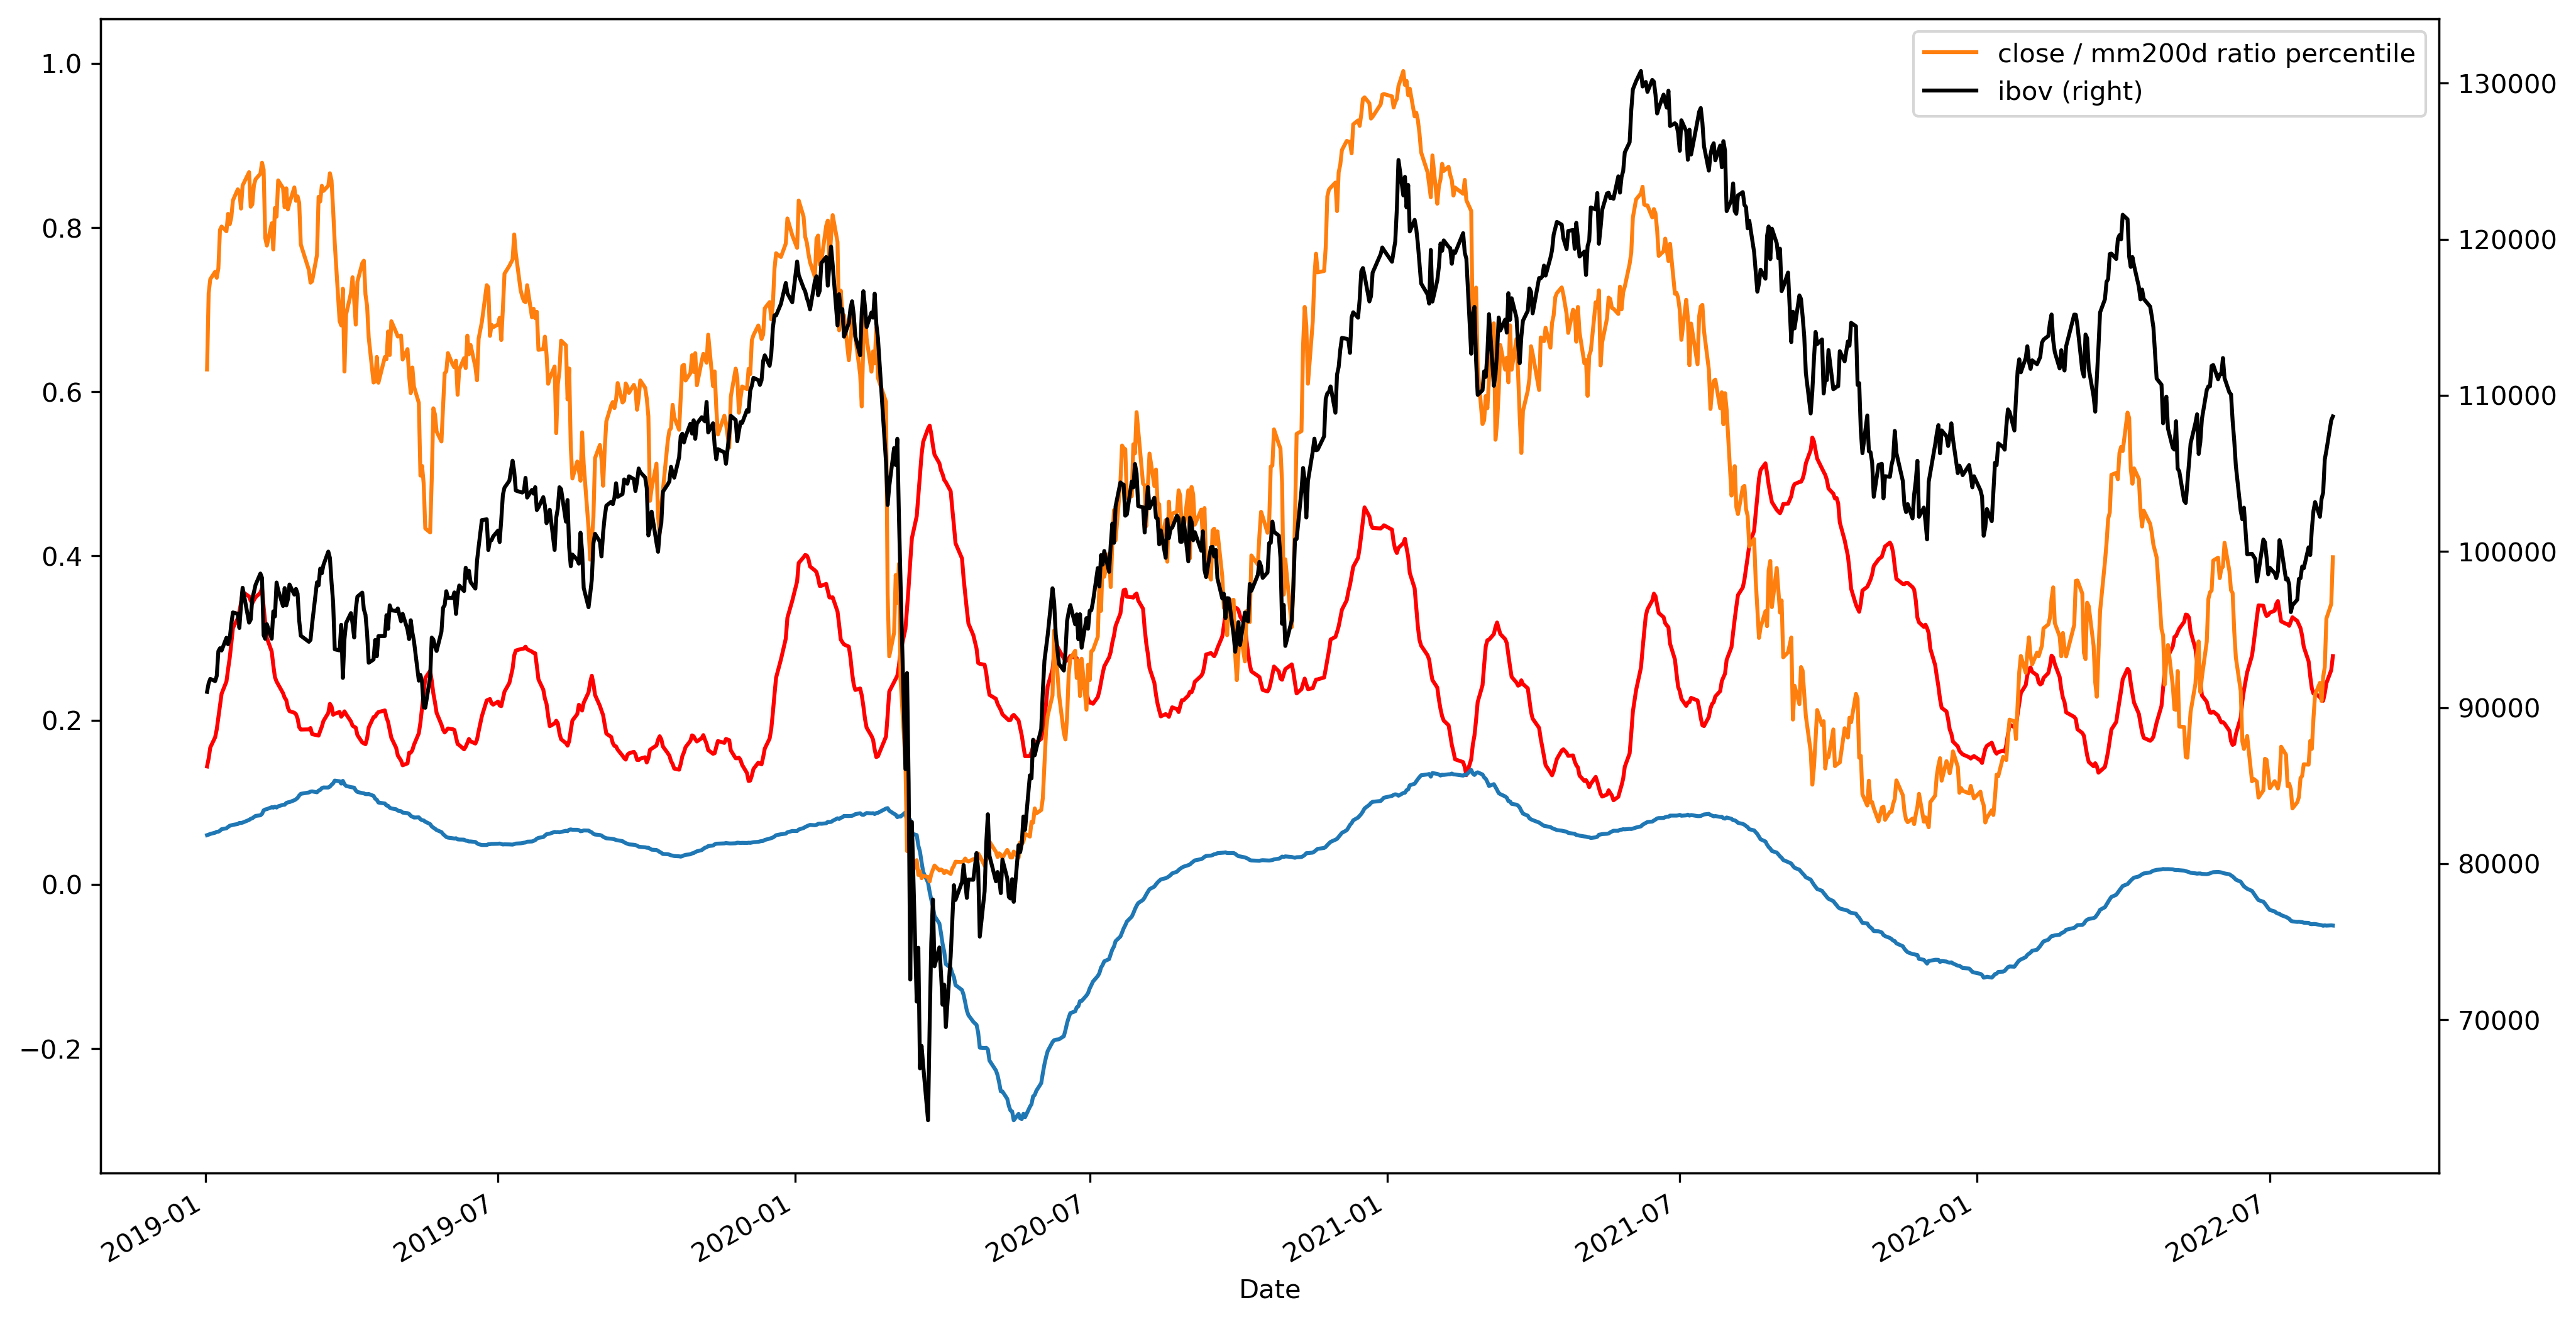

In [49]:
#pd.concat([alta_curto, baixa_curto], axis=1).loc['2019':].plot(kind='area', color=['#BDE7BD', '#FFB6B3'], linewidth=0, legend=False)

(ta.ADX(ibov['High'], ibov['Low'], ibov['Close'], timeperiod=14)/100).loc['2019':].plot(color='red')
((ibov['mm50d'] - ibov['mm200d']) / ibov['Close']).loc['2019':].plot()

ibov.loc['2019':]['perc'].plot(label='close / mm200d ratio percentile', legend=True)

ibov.loc['2019':]['Close'].plot(secondary_y=True, color='black', label='ibov', legend=True)

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter

In [51]:
ibov_decompose_add = seasonal_decompose(ibov['Close'], model='additive', period=60)

<AxesSubplot:xlabel='Date'>

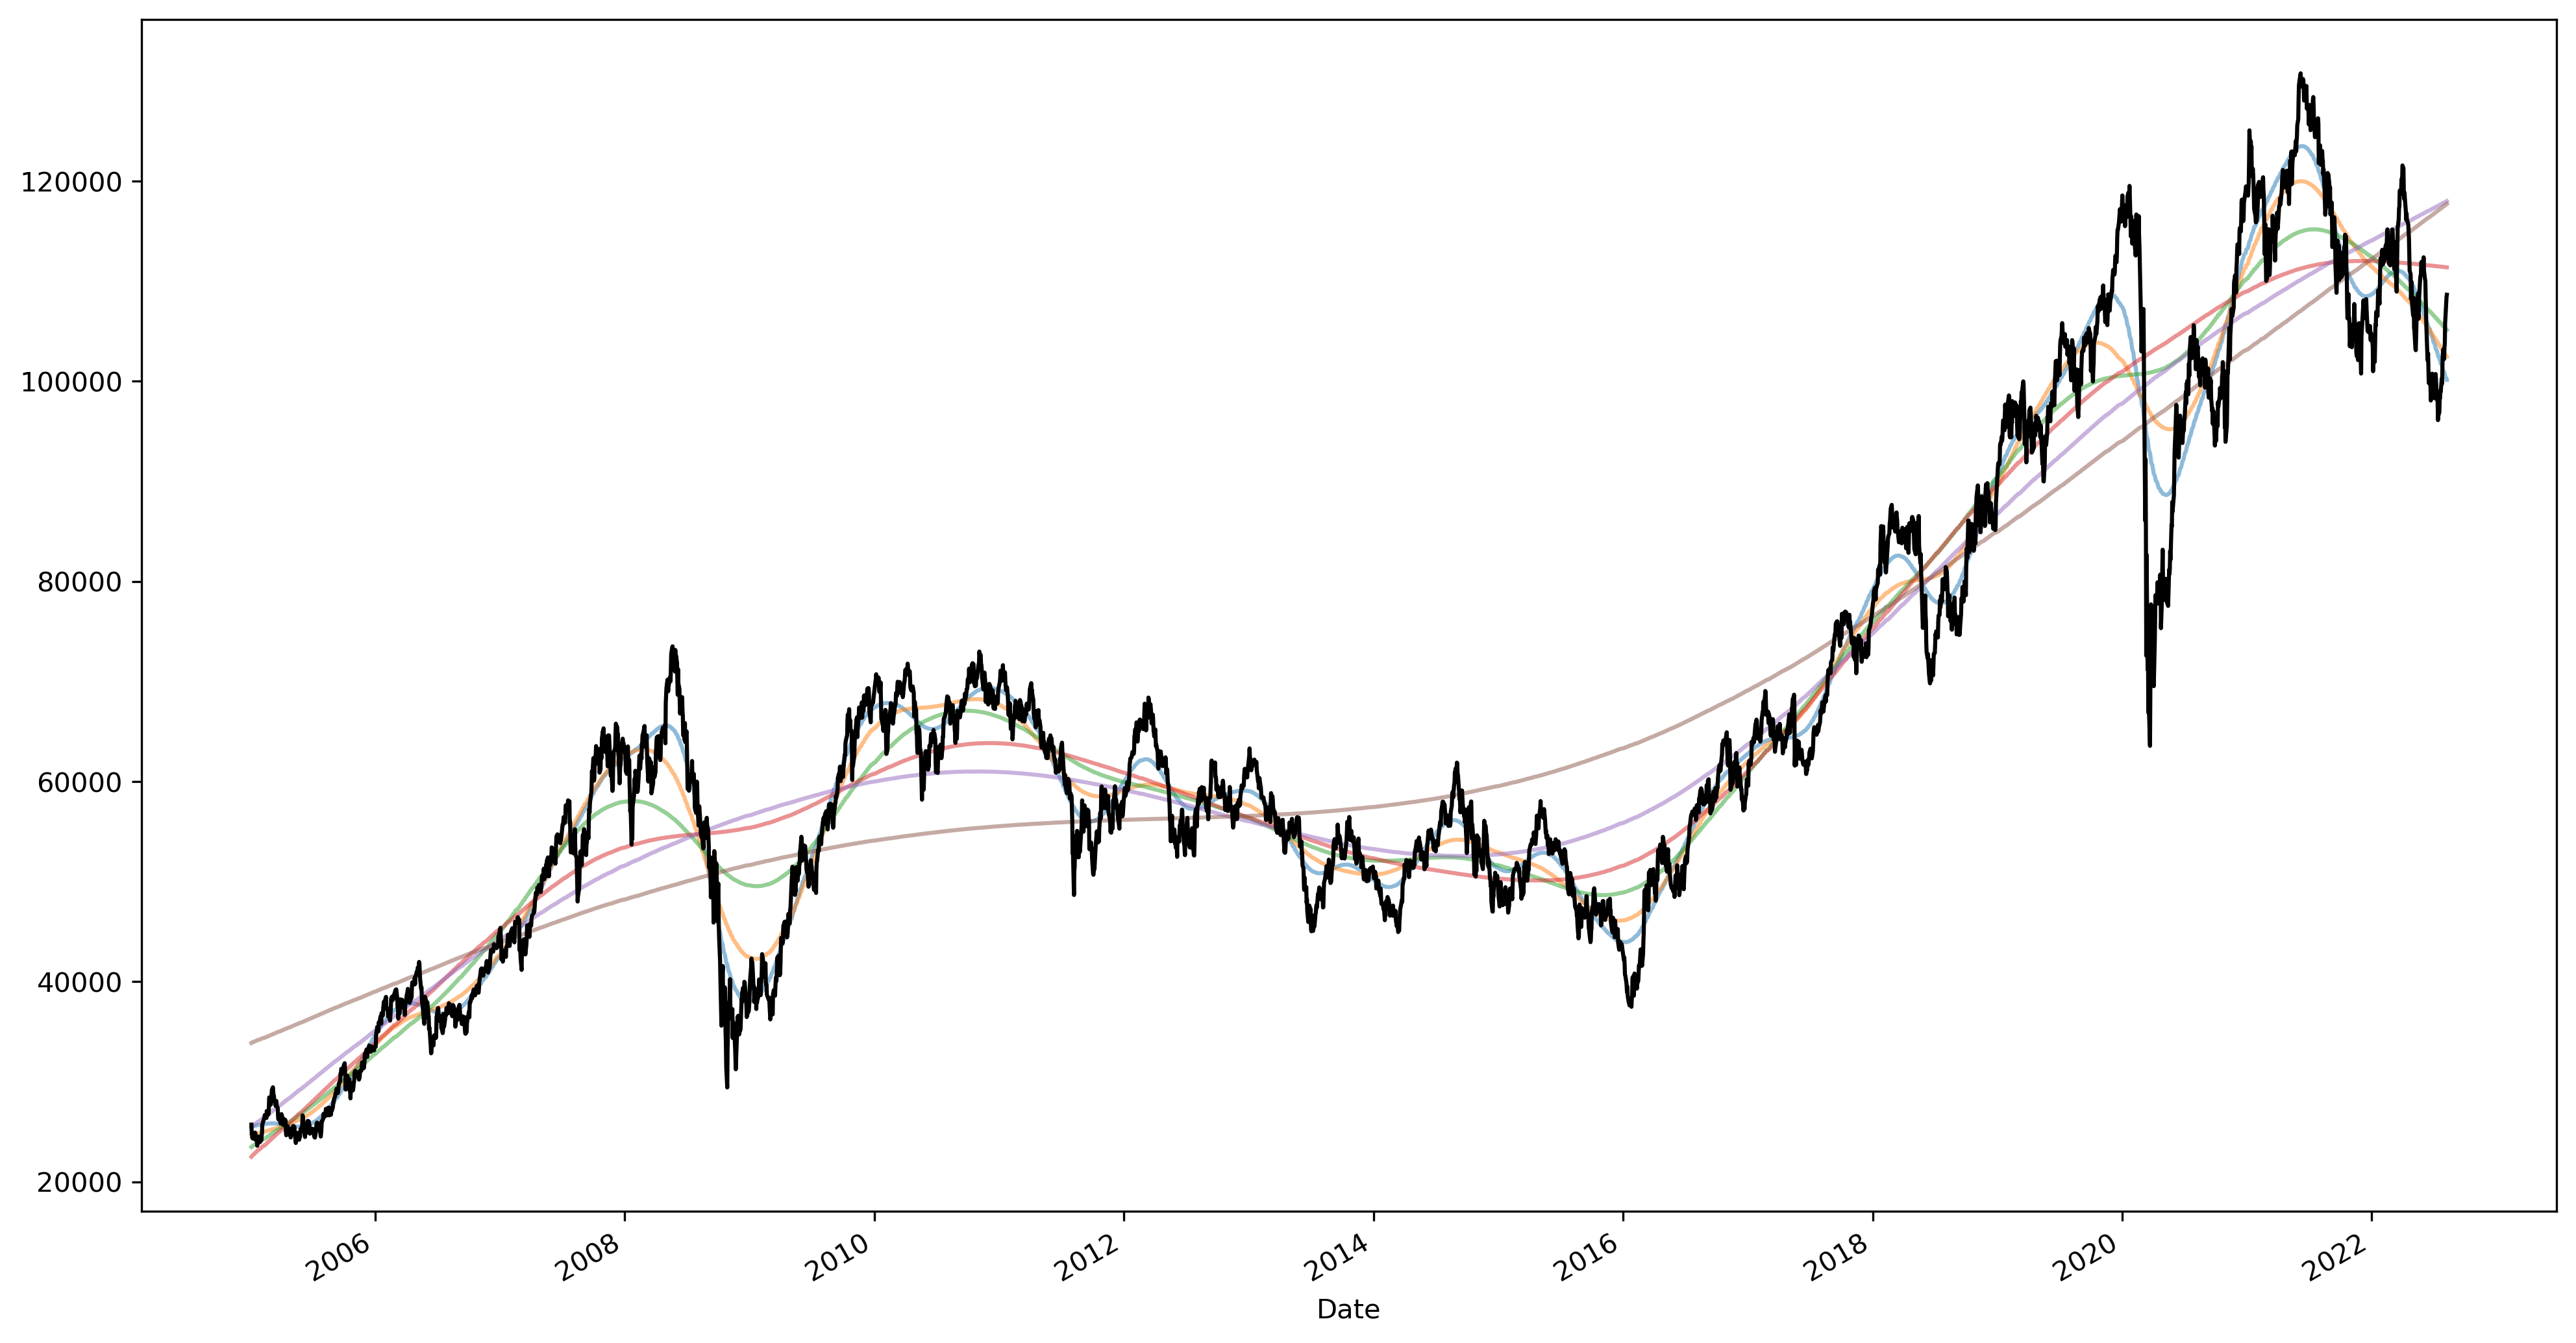

In [52]:
for lamb in [1_000_000, 10_000_000, 100_000_000, 1_000_000_000, 10_000_000_000, 100_000_000_000]:
    hpfilter(ibov['Close'], lamb=lamb)[1].plot(alpha=0.5)

ibov['Close'].plot(color='black')

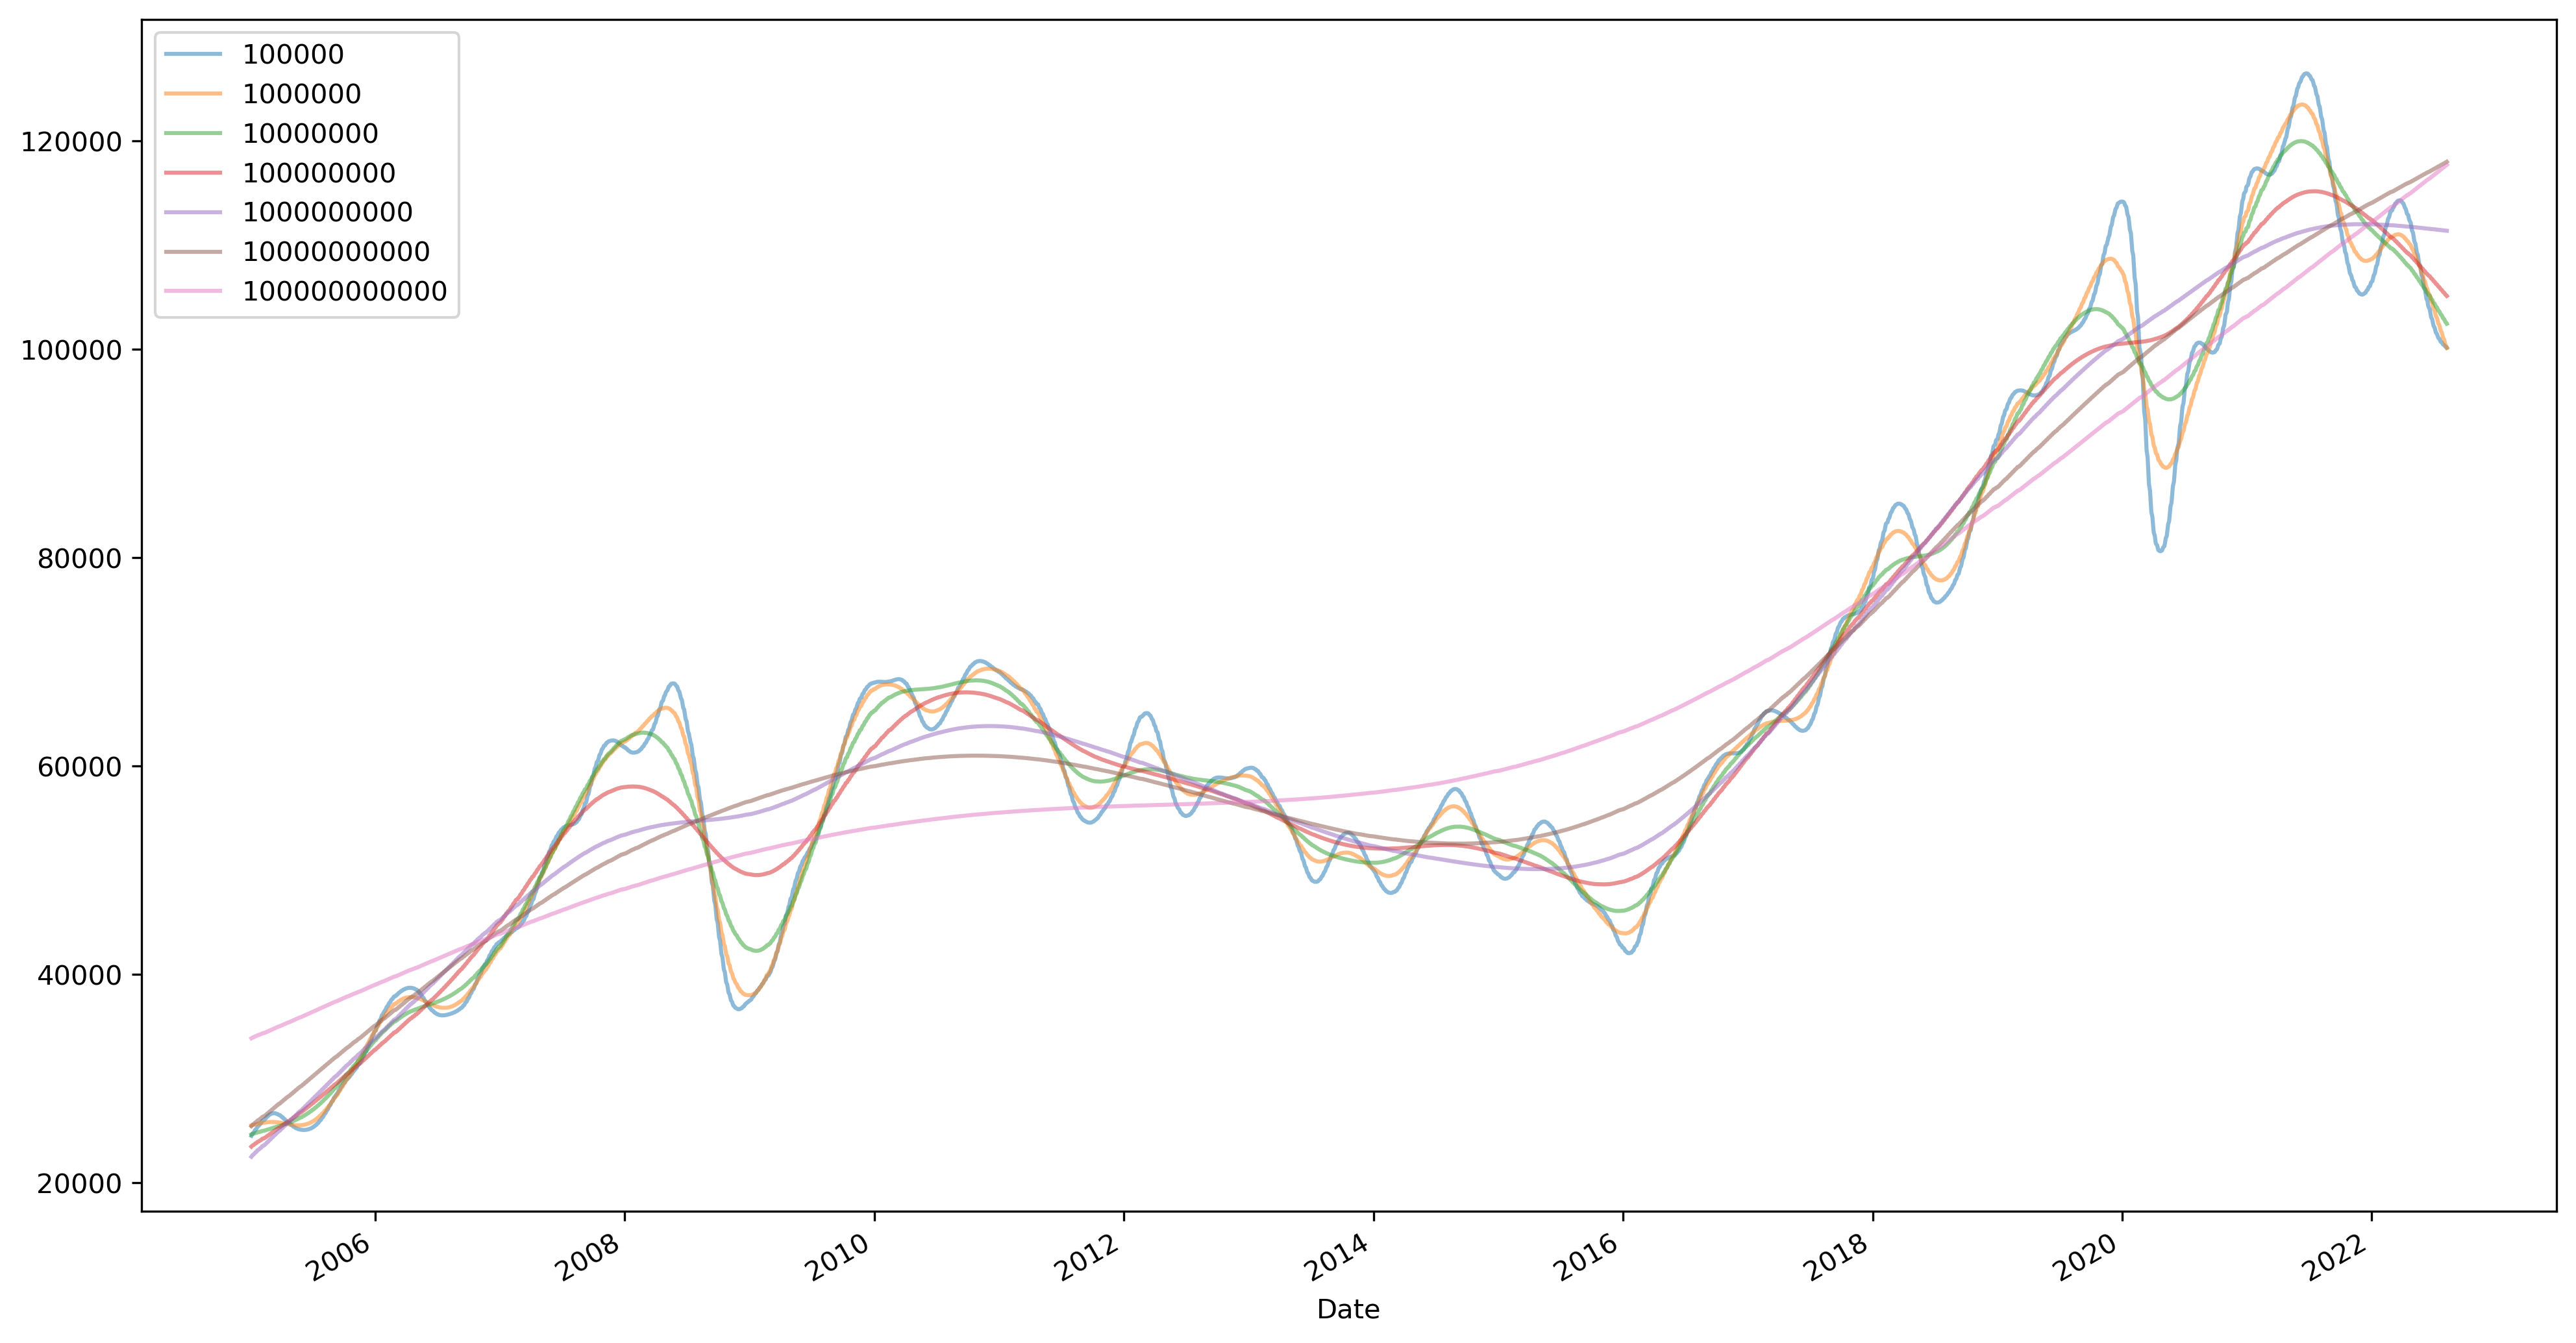

In [53]:
for lamb in [100_000, 1_000_000, 10_000_000, 100_000_000, 1_000_000_000, 10_000_000_000, 100_000_000_000]:
    hpfilter(ibov['Close'], lamb=lamb)[1].plot(alpha=0.5, legend=True, label=lamb)

#ibov['Close'].plot(color='black')

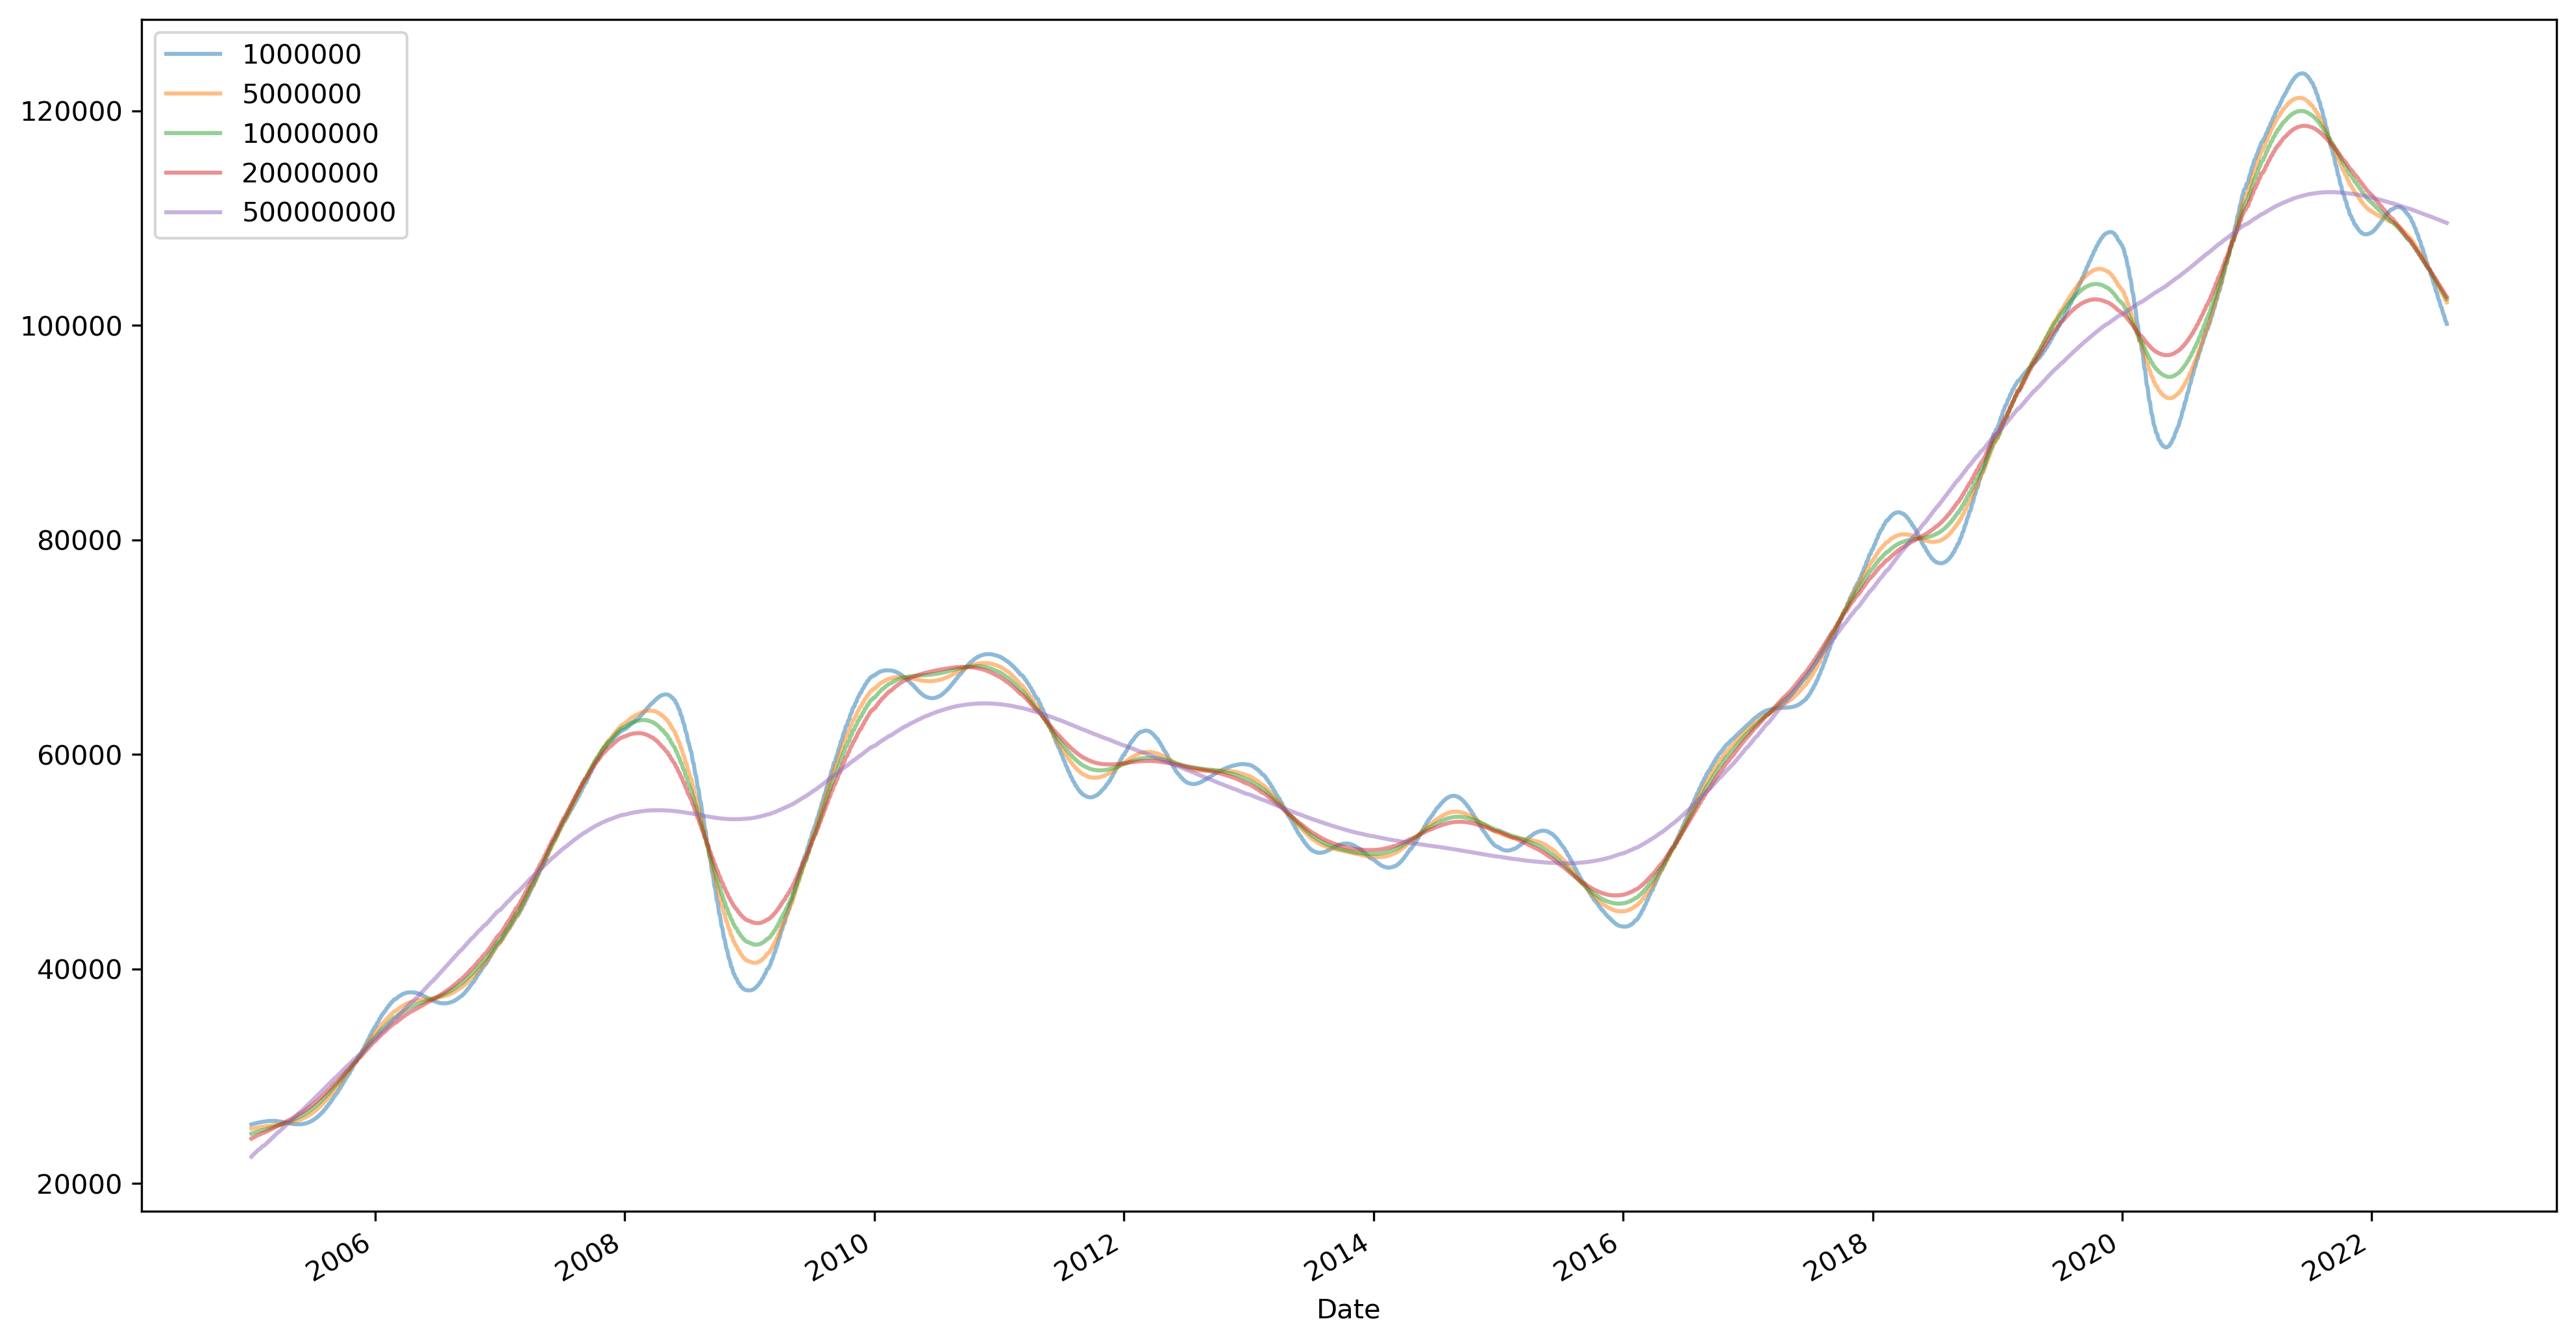

In [54]:
for lamb in [1_000_000, 5_000_000, 10_000_000, 20_000_000, 500_000_000]:
    hpfilter(ibov['Close'], lamb=lamb)[1].plot(alpha=0.5, legend=True, label=lamb)

#ibov['Close'].plot(color='black')

In [55]:
hp_large = hpfilter(ibov['Close'], lamb=20_000_000)[1]

In [56]:
hp_large = pd.DataFrame(hp_large)

In [57]:
hp_large['diff'] = hp_large['Close_trend'] - hp_large['Close_trend'].shift(1)

In [58]:
hp_large['trend'] = hp_large['diff'].apply(lambda x: 1 if x > 0 else -1)

<AxesSubplot:>

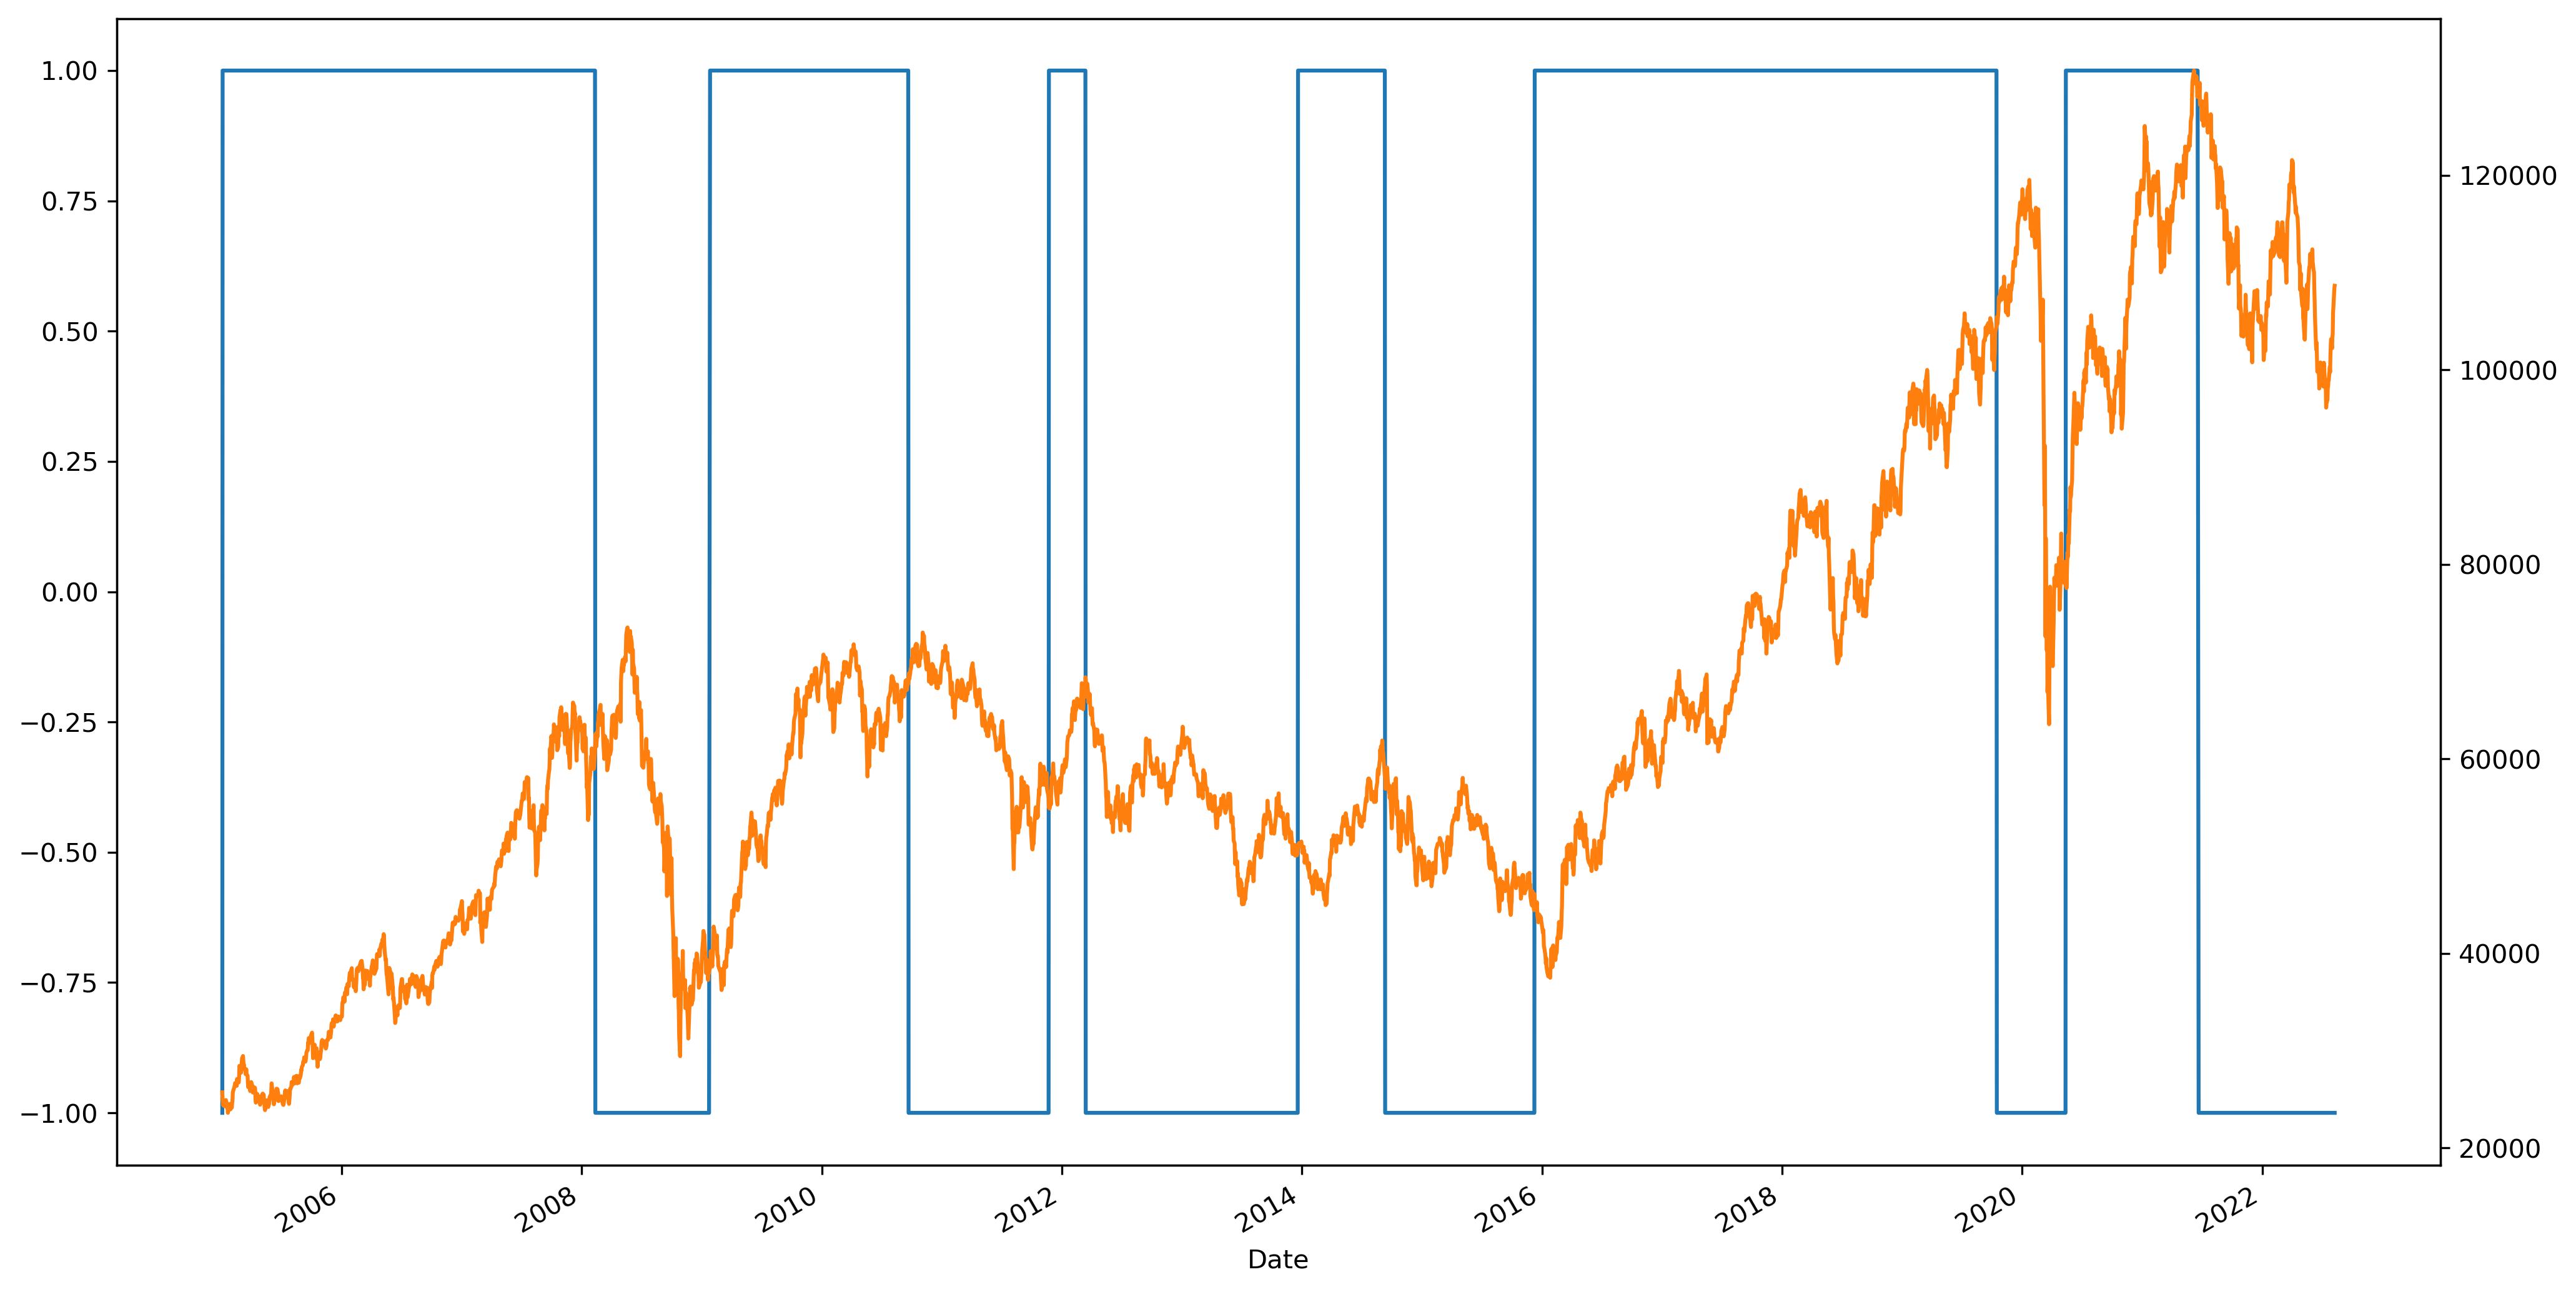

In [59]:
hp_large['trend'].plot()
ibov['Close'].plot(secondary_y=True)